# Prosper Loan data exploration
## by Andy Watson

## Preliminary Wrangling

Little wrangling is needed.
Udacity provided us with a clean csv file from Prosper Financials.
But we will change the ListingCreationDate column from object to datetime format. We are also going to manipulate the dataframe quite a bit prepare it for the data analysis steps.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [3]:
loan = pd.read_csv('prosperLoanData.csv')

### Prepare Data for Analysis

Below I make a few adjustments to the loan data frame.

1. Create a data frame for loans created up through 2008. I will limit my investigations through 2008 because all those loans terms should've been completed by 2014 (the longest term is 5 years and 2013-5=2008). I will also change the ListingCreationDate variable to datetime.

2. Create "Successful" (rename "Completed") and "Unsuccessful" (including both "Chargedoff" and "Defaulted") columns.

3. Create an ROI (return on investment) column.

4. Turn the ordinal variables (that I will be investigating) into categorical variables.

5. Create lists of each type of variable for the variables I'll be investigating.

ROI = (LP_CustomerPyaments - LoanOrignalAmount - LP_ServiceFees - LP_CollectionFees + LP_NonPrincipalRecoverypayments)/LoanOriginalAmount

In [4]:
# make a copy of the data frame
loans_to_2008 = loan.copy()

# change the ListingCreationDate variable to datetime format
loans_to_2008['ListingCreationDate'] = pd.to_datetime(loans_to_2008['ListingCreationDate']) 

In [5]:
# choose the loans made from 2005 through 2008
loans_to_2008 = (loans_to_2008[loans_to_2008['ListingCreationDate'].dt.year <= 2008])
# the dataframe needs a continuous index
loans_to_2008.reset_index(drop=True, inplace=True)

In [6]:
loans_to_2008.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.00,0.00,0.00,1.0,0,0,0.0,258
1,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.00,0.00,0.00,1.0,0,0,0.0,41
2,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,-0.88,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53
3,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Chargedoff,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,-54.61,0.0,6012.65,6012.67,268.96,1.0,0,0,0.0,85
4,1017340630713945364DA6B,241498,2007-11-30 20:33:49.227,D,36,Completed,2010-12-12 00:00:00,0.21488,0.2075,0.1975,...,-51.12,0.0,0.00,0.00,0.00,1.0,0,0,0.0,53


In [7]:
# creating successful and unsuccessful columns
# create a dictionary so you can map the values onto the new category names

dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
dict_map
loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)

In [8]:
# creating the return on investment variable
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 


In [9]:
# as an exercise, I'll turn these ordinal variables into categories computationally.

# convert CreditGrade and IncomeRange into ordered categorical types
ordinal_var_dict = {'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC'],
                    'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans_to_2008[var] = loans_to_2008[var].astype(ordered_var)

In [10]:
numeric_vars = ['AmountDelinquent', 'CreditScoreRangeUpper', 'CreditScoreRangeLower']
percent_vars = ['DebtToIncomeRatio']
ordinal_vars = ['CreditGrade', 'IncomeRange']
nominal_vars = ['BorrowerState', 'Occupation']
binary_vars = ['IsBorrowerHomeowner', 'EmploymentStatus']

### What is the structure of your dataset?

The file contains data on 113,937 loans (rows) with 81 variables (columns). 

Variables include loan amount, interest rate, information about borrower's financial history, and current loan status. 

The data was collected from 2005 through 2014.

### What is/are the main feature(s) of interest in your dataset?

My goal here is to find variables that can accurately predict a loan's outcome. 

In order to make the project manageable, I will restrict my focus to information about the borrower.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

#### Quantitative Variables:

I expect the borrower's credit rating score to accurately predict loan outcomes. The credit rating is created by financial institutions to assess a borrower's credit risk based on current and historical financial data about the borrower. 

Borrower income range and  debt to income ratio should also correlate strongly with loan outcomes.

#### Categorical Variables:

I will also explore two categorical variables: borrower's state, and borrower occupation.

#### Loan outcome data

##### The first primary variable I tried was LoanStatus: the current status of the loan: 

Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.

In order to compare likes to likes and to avoid comparing new loans with older ones (the new ones will of course have a much lower default rate), I will restrict my analysis to loans that originated from 2005 through 2008. The loans originating in this time period were all either 12 or 36 month loans. Therefore, according to the original loan terms, they should've been completed long before 2014, when they stopped updating the data. For that date range, there were 29056 loans.

I created a new variable called NewLoanStatus that divided loans into those that had been completed successfully, and those that had not been completed successfully.

I combined the Chargedoff and Defaulted categories into one category 'Unsuccessful' and the Completed category I renamed 'Successful'. (The only other category applicable to my time range was Cancelled -- but I wasn't sure if a cancelled loan should count as a success or a failure, and there were only 5 of them anyway, so I ignored that category.)

Soon I doubted the sufficiency of this initial 'Unsuccessful' / 'Successful' metric. It didn't account for how much of a loan was paid off before it was cancelled or defaulted. 

##### So I created another primary variable:

I created a new column called 'ROI', where I calculated the return on investment using this formula:

(loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 

## Preliminary Investigation of Data 

In [11]:
loan.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [12]:
loan.info

<bound method DataFrame.info of                      ListingKey  ListingNumber            ListingCreationDate  \
0       1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1       10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2       0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3       0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4       0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   
...                         ...            ...                            ...   
113932  E6D9357655724827169606C         753087  2013-04-14 05:55:02.663000000   
113933  E6DB353036033497292EE43         537216  2011-11-03 20:42:55.333000000   
113934  E6E13596170052029692BB1        1069178  2013-12-13 05:49:12.703000000   
113935  E6EB3531504622671970D9E         539056  2011-11-14 13:18:26.597000000   
113936  E6ED3600409833199F711B7        1140093  2014-01-15 09:27:37.657000000

In [13]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [14]:
# show right side of dataframe
loan_right = loan.iloc[0:1000, 63:76].copy()
loan_right.head()

,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
0,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0
1,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0
3,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0
4,15000,2013-09-20 00:00:00,Q3 2013,36CE356043264555721F06C,563.97,2819.85,1563.22,1256.63,-60.27,0.0,0.0,0.0,0.0


In [15]:
# show instances where the debth was charged off
loan_right[loan_right['LP_NonPrincipalRecoverypayments'] > 0].head()

,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
17,10000,2006-08-22 00:00:00,Q3 2006,893E3365582060699EBBADA,334.54,5325.33,3987.33,1338.00,-54.61,0.00,6012.65,6012.67,268.96
103,15000,2012-04-19 00:00:00,Q2 2012,F11E34621201188152DD3DA,579.63,3968.89,1119.05,2849.84,-49.41,-813.65,13880.95,13880.95,1600.00
138,3000,2012-03-21 00:00:00,Q1 2012,87C83528199783859742DC3,127.34,127.34,23.82,103.52,-5.90,0.00,2976.18,0.00,764.27
185,6000,2010-08-09 00:00:00,Q3 2010,367B348955246532073DD98,234.30,3748.80,2155.59,1593.21,-67.39,0.00,3844.41,3844.41,685.00
251,17500,2006-11-13 00:00:00,Q4 2006,AE023364899153293DA6164,614.64,17565.17,13663.22,3901.95,-106.75,-1106.34,3842.60,2221.08,889.34


In [16]:
loan.value_counts()

Series([], dtype: int64)

In [17]:
loan.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,...,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,...,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,...,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000,0.156290,0.134000,0.124200,0.115670,0.042400,0.074080,3.000000,4.000000,...,-73.180000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,6.005540e+05,36.000000,0.209760,0.184000,0.173000,0.161500,0.072400,0.091700,4.000000,6.000000,...,-34.440000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000
75%,8.926340e+05,36.000000,0.283810,0.250000,0.240000,0.224300,0.112000,0.116600,5.000000,8.000000,...,-13.920000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,115.000000
max,1.255725e+06,60.000000,0.512290,0.497500,0.492500,0.319900,0.366000,0.283700,7.000000,11.000000,...,32.060000,0.000000,25000.000000,25000.000000,21117.900000,1.012500,39.000000,33.000000,25000.000000,1189.000000


In [18]:
loan['LoanStatus']

0                      Completed
1                        Current
2                      Completed
3                        Current
4                        Current
                   ...          
113932                   Current
113933    FinalPaymentInProgress
113934                   Current
113935                 Completed
113936                   Current
Name: LoanStatus, Length: 113937, dtype: object

In [19]:
loan.groupby('LoanStatus').describe()

ListingNumber                                          \
                               count           mean            std       min   
LoanStatus                                                                     
Cancelled                        5.0   87767.200000  180178.635718     908.0   
Chargedoff                   11992.0  364864.921364  197898.726241     156.0   
Completed                    38074.0  388419.870121  213516.255126       4.0   
Current                      56576.0  876833.378199  210349.150769  464139.0   
Defaulted                     5018.0  232427.769829  189488.459787      99.0   
FinalPaymentInProgress         205.0  747528.004878  202541.470503  489610.0   
Past Due (1-15 days)           806.0  710421.168734  163273.523789  471640.0   
Past Due (16-30 days)          265.0  703710.335849  150930.601944  492772.0   
Past Due (31-60 days)          363.0  712121.658402  154116.557782  491495.0   
Past Due (61-90 days)          313.0  690544.562300  136034.292526  488826.0   
Past Due (91-120 days)         304.0  669112.799342  120903.929615  482134.0   
Past Due (>120 days)            16.0  649402.625000  111548.326149  517786.0   

                                                                       Term  \
                              25%       50%         75%        max    count   
LoanStatus                                                                    
Cancelled                 7646.00    8912.0    11364.00   410006.0      5.0   
Chargedoff              188513.75  369917.0   534035.50   932346.0  11992.0   
Completed               221154.50  425475.5   529267.50  1204824.0  38074.0   
Current                 694592.50  883436.0  1057011.50  1255725.0  56576.0   
Defaulted                69063.75  178389.0   367876.25  1099553.0   5018.0   
FinalPaymentInProgress  569532.00  719603.0   908166.00  1240719.0    205.0   
Past Due (1-15 days)    575699.50  662199.5   830913.00  1184124.0    806.0   
Past Due (16-30 days)   588835.00  668132.0   801508.00  1123445.0    265.0   
Past Due (31-60 days)   583373.00  665787.0   840125.00  1112078.0    363.0   
Past Due (61-90 days)   591478.00  651766.0   788166.00  1069344.0    313.0   
Past Due (91-120 days)  573197.50  640280.0   765599.25  1016433.0    304.0   
Past Due (>120 days)    548950.25  630783.5   766740.50   829185.0     16.0   

                                   ... InvestmentFromFriendsAmount            \
                             mean  ...                         75%       max   
LoanStatus                         ...                                         
Cancelled               36.000000  ...                         0.0      0.00   
Chargedoff              38.029353  ...                         0.0  12500.00   
Completed               36.613962  ...                         0.0  25000.00   
Current                 44.511736  ...                         0.0   3000.00   
Defaulted               36.841770  ...                         0.0   8200.00   
FinalPaymentInProgress  39.278049  ...                         0.0    250.00   
Past Due (1-15 days)    43.354839  ...                         0.0    845.00   
Past Due (16-30 days)   43.698113  ...                         0.0    525.58   
Past Due (31-60 days)   44.066116  ...                         0.0      0.00   
Past Due (61-90 days)   43.974441  ...                         0.0      0.00   
Past Due (91-120 days)  44.605263  ...                         0.0      0.00   
Past Due (>120 days)    46.500000  ...                         0.0      0.00   

                       Investors                                            \
                           count        mean         std  min    25%   50%   
LoanStatus                                                                   
Cancelled                    5.0   24.600000   22.678183  6.0   7.00  23.0   
Chargedoff               11992.0   96.110657  102.788349  1.0  28.00  61.0   
Completed                38074.0  108.223854 

In [20]:
loan.groupby('LoanStatus').mean()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
LoanStatus,,,,,,,,,,,,,,,,,,,,,
Cancelled,87767.200000,36.000000,0.205826,0.184400,0.178400,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,24.600000
Chargedoff,364864.921364,38.029353,0.257752,0.235397,0.224656,0.218423,0.116322,0.123379,2.882871,5.390742,...,-46.863075,-49.842038,4662.518525,4608.299671,136.912133,0.997808,0.085474,0.036191,32.136696,96.110657
Completed,388419.870121,36.613962,0.208781,0.186422,0.176595,0.163086,0.086753,0.102430,3.907648,6.536513,...,-57.650019,-5.104060,0.000000,0.000000,0.000000,0.998702,0.092452,0.051584,36.283888,108.223854
Current,876833.378199,44.511736,0.213740,0.183771,0.173771,0.163595,0.073381,0.090227,4.288426,5.837952,...,-55.021413,-1.852073,0.000000,0.000000,0.000000,0.998664,0.009191,0.002209,0.585536,57.140148
Defaulted,232427.769829,36.841770,0.238925,0.223077,0.212097,0.209420,0.111961,0.123416,3.015920,5.619900,...,-39.681192,-116.638448,4761.624705,4459.202419,243.689113,0.999261,0.075528,0.028298,16.612698,100.659426
FinalPaymentInProgress,747528.004878,39.278049,0.229558,0.196960,0.186960,0.176569,0.083253,0.093316,3.956098,5.751220,...,-68.433366,-4.627024,0.000000,0.000000,0.000000,0.996479,0.009756,0.014634,2.560878,76.751220
Past Due (1-15 days),710421.168734,43.354839,0.263828,0.230797,0.220797,0.208204,0.097967,0.110621,3.373449,5.042184,...,-79.069007,-72.582581,0.000000,0.000000,0.000000,0.997539,0.014888,0.002481,1.166253,66.997519
Past Due (16-30 days),703710.335849,43.698113,0.268445,0.235258,0.225258,0.211939,0.100970,0.110969,3.275472,4.969811,...,-74.676415,-83.735585,0.000000,0.000000,0.000000,0.997878,0.011321,0.011321,3.517283,73.509434
Past Due (31-60 days),712121.658402,44.066116,0.265734,0.232978,0.222978,0.210208,0.099552,0.110655,3.327824,5.110193,...,-70.067135,-64.730523,0.000000,0.000000,0.000000,0.997508,0.013774,0.000000,0.000000,62.652893


In [21]:
loan.groupby('Term').describe()

ListingNumber                                                     \
             count           mean            std       min        25%   
Term                                                                    
12          1614.0  596105.513631   74617.647800  319654.0  534315.75   
36         87778.0  569803.789663  335151.727576       4.0  315996.00   
60         24545.0  837688.360114  203513.631937  464735.0  653639.00   

                                      BorrowerAPR            ...  \
           50%         75%        max       count      mean  ...   
Term                                                         ...   
12    589994.5   658609.25   741982.0      1614.0  0.216223  ...   
36    534666.5   841837.75  1255725.0     87753.0  0.219431  ...   
60    827167.0  1009196.00  1255149.0     24545.0  0.216843  ...   

     InvestmentFromFriendsAmount           Investors                         \
                             75%       max     count       mean         std   
Term                                                                          
12                           0.0   2975.00    1614.0  65.087980   64.473477   
36                           0.0  25000.00   87778.0  83.671227  104.153692   
60                           0.0  10593.67   24545.0  70.057486  101.229366   

                                       
      min    25%   50%    75%     max  
Term                                   
12    1.0  29.25  47.0   75.0   504.0  
36    1.0   7.00  48.0  117.0  1189.0  
60    1.0   1.00  17.0  112.0   714.0  

[3 rows x 480 columns]

In [22]:
loan.groupby('Term').mean()

,ListingNumber,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
Term,,,,,,,,,,,,,,,,,,,,,
12,596105.513631,0.216223,0.150081,0.140081,0.134658,0.074130,0.060680,4.326100,6.563546,4.915737,...,-21.124318,-8.580409,138.233482,128.697193,2.100372,0.999077,0.048947,0.014250,4.907200,65.087980
36,569803.789663,0.219431,0.193486,0.183404,0.167792,0.084158,0.094762,3.965397,5.868115,2.684294,...,-50.221543,-16.660683,772.827297,749.617007,31.304558,0.998857,0.058625,0.029506,21.047365,83.671227
60,837688.360114,0.216843,0.192991,0.182990,0.172976,0.071499,0.101517,4.311061,6.105724,2.954940,...,-73.042744,-5.967816,478.566374,473.880975,4.621747,0.997574,0.010063,0.002444,1.235570,70.057486


In [23]:
loan['ListingCreationDate'].dtype

dtype('O')

In [24]:
# this was causing the system to crash, so I commented it 
# years = loan.ListingCreationDate.apply(lambda x: x[:4])
# print(years)

In [25]:
# loan.groupby('ListingCreationDate').apply(lambda x: x[:4])

In [26]:
# dates_loan = loan.copy()

In [27]:
 # dates_loan['ListingCreationDate']  = dates_loan['ListingCreationDate'].dt.year

In [28]:
# dates_loan.groupby('ListingCreationDate').count()


## Univariate Exploration

First: What is the distribution of loan outcomes?



<AxesSubplot:xlabel='count', ylabel='LoanStatus'>

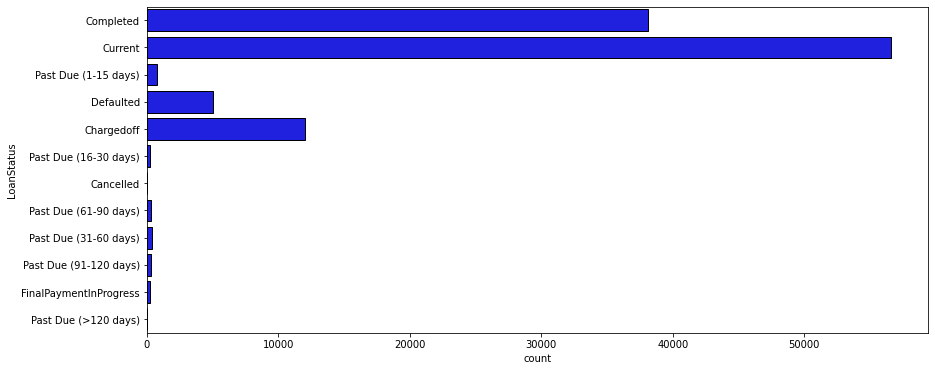

In [29]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loan, y='LoanStatus', color='blue', edgecolor='black')

The Completed category dwarfs all other categories.

I think I should limit my investigations to 2008.

Because all those loans terms should've been completed by 2014 (the longest term is 5 years and 2013-5=2008).

In [30]:
# we moved this calculation to the top
# loans_to_2008 = (loan[loan['ListingCreationDate'].dt.year <= 2008]).copy()

<AxesSubplot:xlabel='count', ylabel='LoanStatus'>

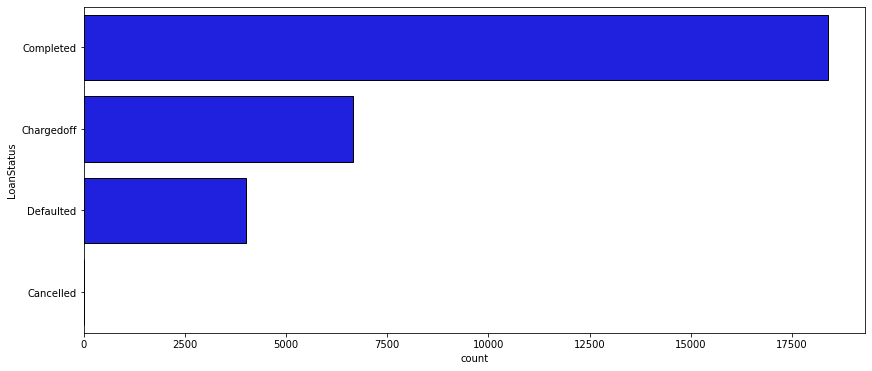

In [31]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='LoanStatus', color='blue', edgecolor='black')

In [32]:
loans_to_2008[loans_to_2008['LoanStatus'] == 'Cancelled'].count()

ListingKey                     5
ListingNumber                  5
ListingCreationDate            5
CreditGrade                    5
Term                           5
                              ..
InvestmentFromFriendsCount     5
InvestmentFromFriendsAmount    5
Investors                      5
NewLoanStatus                  5
ROI                            5
Length: 83, dtype: int64

I looked at the loans created from 2005 to 2008. 

All of those loans's original terms were up by 2014, when they stopped updating our data. Most were completed, but a significate number where charged off or defaulted. Only 5 loans were cancelled. 

Default status is generally declared when a loan is 121 past due. The loan is generally charged off (ie: all hope is abandoned for the recovery of the debt) after 150 days past due. 

It is strange that there's so many loans that are still lingering in Defaulted. 

I should check to see what percentage of the defaulted loans are 5-year loans from 2008. But first I want to look at the above data in terms of percentages.

In [33]:
loans_to_2008.LoanStatus.value_counts()

Completed     18385
Chargedoff     6654
Defaulted      4012
Cancelled         5
Name: LoanStatus, dtype: int64

In [34]:
loans_to_2008.LoanStatus.value_counts().sum()

29056

From 2005 through 2008, Prosper made 29056 loans. By 2014, 18385 loans were completed, 6654 were charged off, 4012 were defaulted, and 5 were cancelled.

<Figure size 1008x432 with 0 Axes>

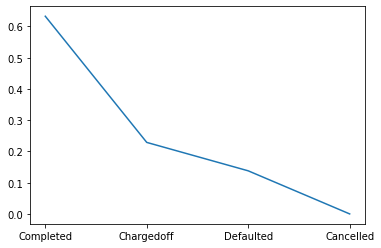

In [35]:
# find the total number of loans created from 2005 through 2008
total = loans_to_2008.LoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.LoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.LoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.plot(category, percentage)

<BarContainer object of 4 artists>

<Figure size 1008x432 with 0 Axes>

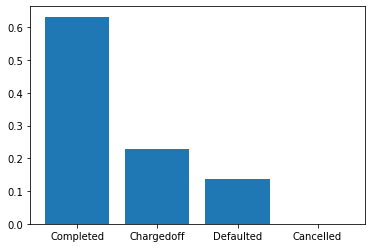

In [36]:
# I think it is easier to see with a bar chart

# find the total number of loans created from 2005 through 2008
total = loans_to_2008.LoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.LoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.LoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)

In [37]:
# I want to know what percent of the Defaulted loans are five year loans
loans_to_2008.groupby('Term').sum()

,ListingNumber,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,ROI
Term,,,,,,,,,,,,,,,,,,,,,
12,319654,0.23135,0.08200,0.0720,0.0,0.0,0.0,0.0,0.0,7,...,0.0000,0.00,0.000000e+00,0.00,1.000,0,1,100.00,105,0.046880
36,5861854010,5688.81977,5325.23955,5027.9006,0.0,0.0,0.0,0.0,0.0,34899,...,-926460.7657,47894492.13,4.643645e+07,2215805.94,29055.011,3978,1989,1519454.88,3373619,-681.960996


Oh!

All these loans were supposed to be paid in either one or three years. So at the very latest, according to the original loan terms, all loans should've been paid off by 2011 (since the loans originated from 2005 through 208).

I don't understand how any could still be in the Defaulted, rather than the ChargedOff category in 2014.

I guess these are cases when people had been paying a little for a long time but then stopped paying altogether a little before they stopped collecting data? How could there be so many loans that were 121 days past due but not yet 150 days past due? It doesn't make sense.

In any case, I think it is safe to say that a loan that is either still defaulted or completely charged off several (or more) years after it should've been completely paid off was an unsuccessful loan.

So let's combine the Chargedoff and Defaulted categories into one category "UnSuccesful Loans", and rename "Completed" as "Successful Loans".

#### Creating the NewLoanStatus Variable

I am going to combine the chargedoff and defaulted LoanStatus categories into a category called Unsuccessful. 

The completed loans I will call Successful.

In [38]:
# get current unique values
loans_to_2008['LoanStatus'].unique()

array(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], dtype=object)

In [39]:
# create a dictionary so you can map the values onto the new category names

dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
dict_map

{'Completed': 'Successful',
 'Chargedoff': 'Unsuccessful',
 'Defaulted': 'Unsuccessful',
 'Cancelled': 'Cancelled'}

In [40]:
# map the values into the new column

loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)
loans_to_2008['NewLoanStatus'].value_counts()

Successful      18385
Unsuccessful    10666
Cancelled           5
Name: NewLoanStatus, dtype: int64

<AxesSubplot:xlabel='count', ylabel='NewLoanStatus'>

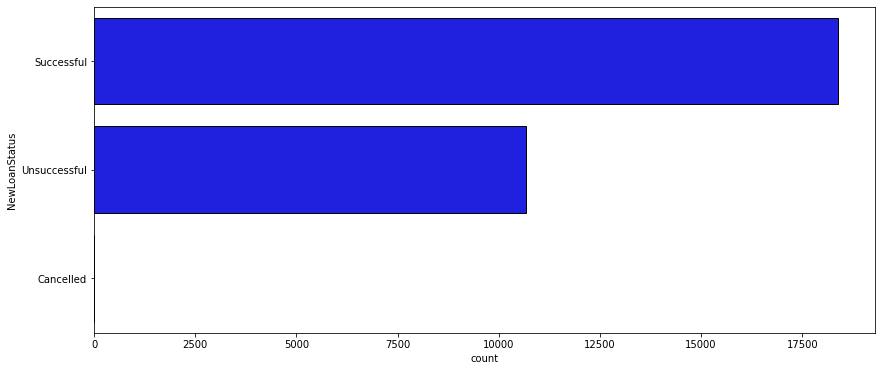

In [41]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='NewLoanStatus', color='blue', edgecolor='black')

#### Calculating the percent of Successful loans

I want to look at the percentages of loans that ended up being either successful or unsuccessful.

<BarContainer object of 3 artists>

<Figure size 1008x432 with 0 Axes>

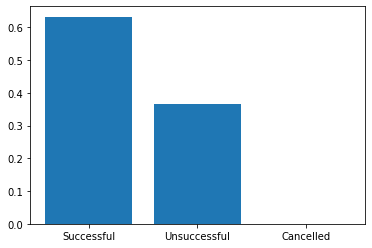

In [42]:
# find the total number of loans created from 2005 through 2008
total = loans_to_2008.NewLoanStatus.value_counts().sum()
# find the percentage of loans in each category of LoanStatus
percentage = loans_to_2008.NewLoanStatus.value_counts()/total
# list the LoanStatus categories
category = loans_to_2008.NewLoanStatus.unique()
plt.figure(figsize=[14, 6])
fig, ax = plt.subplots()
ax.bar(category, percentage)

In [43]:
total

29056

In [44]:
# the number of successful loans is 18385
# the number of total loans is 29056
18385/29056


0.6327436674008811

If we declare all loans that originated between 2005 and 2008 and that were completed by 2014 "Successful", and the rest of those loans (either Defaulted or Chargedoff, and ignoring the 5 Cancelled loans) "Unsuccessful, about 63% of the loans were successful. 

But as I did this, I began to wonder how things would look if we factored in how much money was recovered in the various "Unsuccessful" loans. So I created a return on investment (ROI) column that factored in payments and recoveries. See the top section of this notebook for the programming.

### Graphing the ROI (return on investment) variable

## Note: See the XYZ Section for a discussion of how I came up with this metric and See the top "Prepare Data for Analysis" section to see how I  calculated the ROI variable.

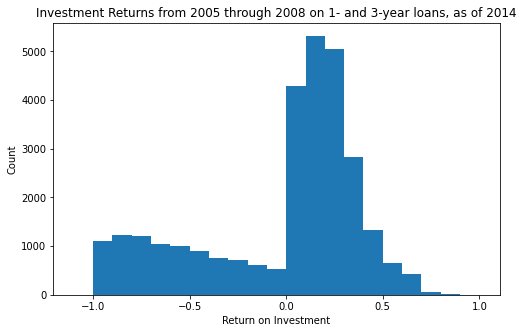

In [45]:
# start with a standard-scaled plot
binsize = .1
bins = np.arange(-1-binsize, 1+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins=bins)
plt.xlabel('Return on Investment')
plt.ylabel('Count')
plt.title('Investment Returns from 2005 through 2008 on 1- and 3-year loans, as of 2014')
plt.show()

The bulk of the loans seem to have either about a 10%, 20%,or 30% return (each of these categories contains over 4000 loans). Fewer, but a still substantial amount of loans have a 40% return (around 3000 loans). About 1000 loans had a 50% return, and then the numbers drop off smoothly for 60% and 70% returns. ROIs higher than that are very rare in the data set.

On the negative side, the -100%, -90%, and -80% ROI columns each contain about 1000 loans, and the counts drop off gradually from there to 0, where there appear to be about 500 loans where the lender broke even.

I want to look at these numbers programmatically now.

In [46]:
loans_to_2008.groupby('ROI').mean()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
ROI,,,,,,,,,,,,,,,,,,,,,
-1.000000,156181.114754,36.0,0.266755,0.252606,0.240639,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,4414.551148,4416.610656,0.00,1.0,0.086066,0.028689,33.934426,57.803279
-0.997857,19063.000000,36.0,0.234970,0.227500,0.210000,NaN,NaN,NaN,NaN,NaN,...,0.00,-1.37,6100.000000,6100.000000,11.70,1.0,0.000000,0.000000,0.000000,38.000000
-0.995550,212778.000000,36.0,0.116460,0.109500,0.099500,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,10000.000000,10000.000000,44.50,1.0,1.000000,0.000000,0.000000,315.000000
-0.994118,75377.000000,36.0,0.297760,0.290000,0.285000,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,2550.000000,2550.000000,0.00,1.0,0.000000,0.000000,0.000000,34.000000
-0.992180,21868.000000,36.0,0.295250,0.287500,0.270000,NaN,NaN,NaN,NaN,NaN,...,0.00,-2.39,2550.000000,2550.000000,17.55,1.0,0.000000,0.000000,0.000000,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.005920,379979.000000,36.0,0.374530,0.350000,0.340000,NaN,NaN,NaN,NaN,NaN,...,-21.79,-61.52,0.000000,0.000000,0.00,1.0,0.000000,0.000000,0.000000,14.000000
1.032613,316650.000000,36.0,0.374530,0.350000,0.340000,NaN,NaN,NaN,NaN,NaN,...,-18.33,-450.00,1003.120000,945.260000,1442.14,1.0,0.000000,0.000000,0.000000,22.000000
1.130300,231726.000000,36.0,0.370360,0.350000,0.340000,NaN,NaN,NaN,NaN,NaN,...,-8.74,-587.28,1000.000000,333.700000,1534.28,1.0,0.000000,0.000000,0.000000,18.000000


In [47]:
# create bins for the ROI values
binsize=.1
bins = np.arange(-1-binsize, 1+binsize, binsize)

roi_bins = pd.cut(loans_to_2008['ROI'], bins)

# try groupby again
loans_to_2008.groupby(roi_bins)['ROI'].count()

ROI
(-1.1, -1.0]         244
(-1.0, -0.9]         853
(-0.9, -0.8]        1225
(-0.8, -0.7]        1208
(-0.7, -0.6]        1052
(-0.6, -0.5]         994
(-0.5, -0.4]         905
(-0.4, -0.3]         747
(-0.3, -0.2]         711
(-0.2, -0.1]         612
(-0.1, 8.88e-16]     539
(8.88e-16, 0.1]     4296
(0.1, 0.2]          5317
(0.2, 0.3]          5051
(0.3, 0.4]          2829
(0.4, 0.5]          1324
(0.5, 0.6]           645
(0.6, 0.7]           421
(0.7, 0.8]            51
(0.8, 0.9]            20
(0.9, 1.0]             6
Name: ROI, dtype: int64

The most common return outcomes are 0-10% (4296 loans), 10-20% (5317 loans), 20-30% (5051 loans), 30-40% (2829) loans, and 40-50% (1324 loans). But there were six negative categories that had close to or more than 1000 loans. And the rest of the negative outcomes were over 500 -- except for the -100 through -110% category, which only 244 loans.

In [48]:
# this 8.888e-16 is confusing. I'm going to see what happens with a smaller bin size
binsize=.05
bins = np.arange(-1-binsize, 1+binsize, binsize)

roi_bins = pd.cut(loans_to_2008['ROI'], bins)

# try groupby again
loans_to_2008.groupby(roi_bins)['ROI'].count()

ROI
(-1.05, -1.0]         244
(-1.0, -0.95]         379
(-0.95, -0.9]         474
(-0.9, -0.85]         605
(-0.85, -0.8]         620
(-0.8, -0.75]         600
(-0.75, -0.7]         608
(-0.7, -0.65]         543
(-0.65, -0.6]         509
(-0.6, -0.55]         527
(-0.55, -0.5]         467
(-0.5, -0.45]         475
(-0.45, -0.4]         430
(-0.4, -0.35]         401
(-0.35, -0.3]         346
(-0.3, -0.25]         397
(-0.25, -0.2]         314
(-0.2, -0.15]         298
(-0.15, -0.1]         314
(-0.1, -0.05]         281
(-0.05, 8.88e-16]     258
(8.88e-16, 0.05]     2182
(0.05, 0.1]          2114
(0.1, 0.15]          2544
(0.15, 0.2]          2773
(0.2, 0.25]          2696
(0.25, 0.3]          2355
(0.3, 0.35]          1662
(0.35, 0.4]          1167
(0.4, 0.45]           831
(0.45, 0.5]           493
(0.5, 0.55]           451
(0.55, 0.6]           194
(0.6, 0.65]           326
(0.65, 0.7]            95
(0.7, 0.75]            34
(0.75, 0.8]            17
(0.8, 0.85]            11
(0.85, 0

OK, never mind. That 8.888e-16 must be how pd.cut() gets around zero. I don't understand why it is afraid of zero, but I'll leave it alone.

### Distributions of a predictor variables 

Now I'll look at the distributions of variables whose affect on loan outcomes I want to study.

#### Income Ranges

<AxesSubplot:xlabel='count', ylabel='IncomeRange'>

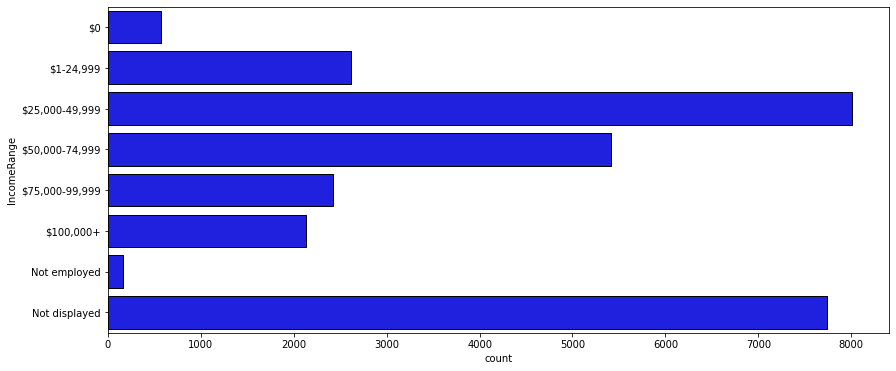

In [49]:
plt.figure(figsize=[14, 6])
sb.countplot(data=loans_to_2008, y='IncomeRange', color='blue', edgecolor='black')


I want to put these columns in order from highest to lowest.

First I need to see all the column names clearly.

In [50]:
loan.groupby('IncomeRange').count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
IncomeRange,,,,,,,,,,,,,,,,,,,,,
$0,621,621,621,576,621,621,606,621,621,621,...,621,621,621,621,621,621,621,621,621,621
"$1-24,999",7274,7274,7274,2607,7274,7274,4571,7274,7274,7274,...,7274,7274,7274,7274,7274,7274,7274,7274,7274,7274
"$100,000+",17337,17337,17337,2116,17337,17337,6064,17337,17337,17337,...,17337,17337,17337,17337,17337,17337,17337,17337,17337,17337
"$25,000-49,999",32192,32192,32192,7977,32192,32192,16344,32192,32192,32192,...,32192,32192,32192,32192,32192,32192,32192,32192,32192,32192
"$50,000-74,999",31050,31050,31050,5378,31050,31050,12789,31050,31050,31050,...,31050,31050,31050,31050,31050,31050,31050,31050,31050,31050
"$75,000-99,999",16916,16916,16916,2401,16916,16916,6442,16916,16916,16916,...,16916,16916,16916,16916,16916,16916,16916,16916,16916,16916
Not displayed,7741,7741,7741,7741,7741,7741,7741,7716,7741,7741,...,7741,7741,7741,7741,7741,7741,7741,7741,7741,7741
Not employed,806,806,806,157,806,806,532,806,806,806,...,806,806,806,806,806,806,806,806,806,806


In [51]:
# looking up the income ranges values to check against graph outcomes
loans_to_2008['IncomeRange'].value_counts()

$25,000-49,999    8008
Not displayed     7741
$50,000-74,999    5412
$1-24,999         2617
$75,000-99,999    2417
$100,000+         2128
$0                 576
Not employed       157
Name: IncomeRange, dtype: int64

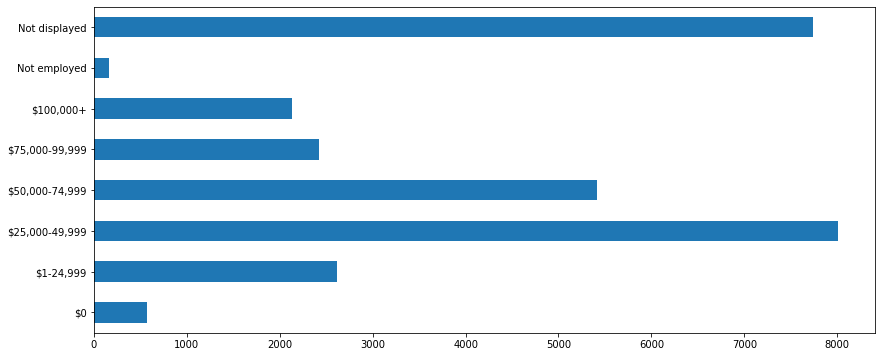

In [52]:
plt.figure(figsize=[14, 6])
order = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']
loans_to_2008['IncomeRange'] = pd.Categorical(loans_to_2008['IncomeRange'], ordered=True, categories= order)
loans_to_2008['IncomeRange'].value_counts(sort=False).plot(kind='barh');

<AxesSubplot:>

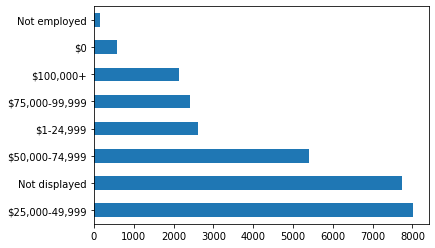

In [53]:
loans_to_2008['IncomeRange'].value_counts(sort=True).plot(kind='barh')

<AxesSubplot:>

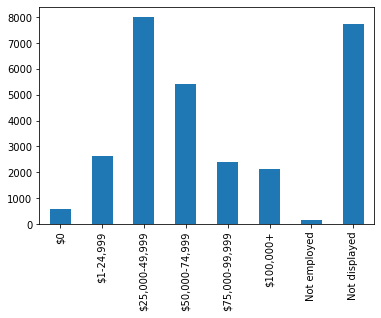

In [54]:
loans_to_2008['IncomeRange'].value_counts(sort=False).plot(kind='bar')

Of the 29058 loans made by Prosper from 2005 through 2008:

Around 8000 loans went to people at the moderate-to-low income range of \\$25K-\\$49,999. "Not Displayed" had a similar amount. The next highest category is about 5500 loans in the moderate-to-high \\$50K-\\$74,999 range. About 500 loans were made to people with no income and even fewer to unemployed people. Each of the three remaining categories (one under \\$25K and two over \\$75K) accounted for 3000 loans.

It would be interesting to see how the percentage of loans given to people at various income levels relates to the percentage of people in the country at those various income ranges.But that is outside the scope of this project.

We can say that there is a fair amount of data for all the income ranges (at least 2,000 loans for all categories except for the \\$0 income; and much more for people with in the medium income ranges). Enough that the information should be statistically significant. 

I am surprised how many incomes were not recorded. I'm not sure what to do with that category. I will perhaps exclude those loans when looking for trends in the bivariate and multivariate graphs.

Now let's look at credit grade distributions.

<AxesSubplot:xlabel='count', ylabel='CreditGrade'>

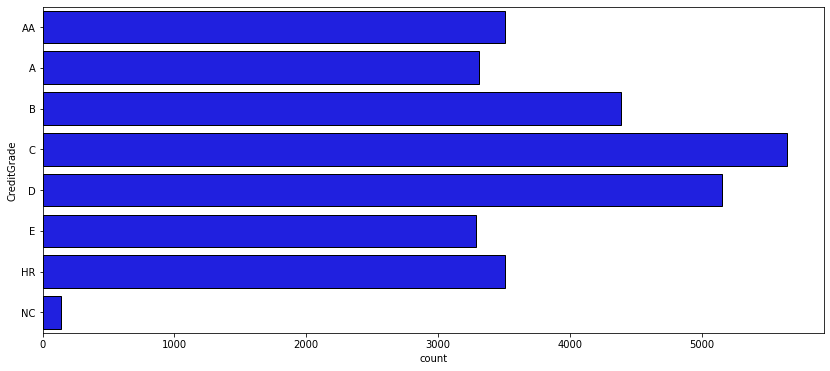

In [55]:
plt.figure(figsize=[14, 6])
order = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC']
sb.countplot(data=loans_to_2008, y='CreditGrade', color='blue', edgecolor='black', order=order)

In [56]:
loans_to_2008.CreditGrade.value_counts()

C     5644
D     5151
B     4386
AA    3508
HR    3508
A     3313
E     3289
NC     141
Name: CreditGrade, dtype: int64

In [57]:
loans_to_2008.CreditGrade.value_counts().sum()

28940

In [58]:
loans_to_2008.shape[0]

29056

There seem to be few less credit ratings than total loans (29056 - 28940 = 16).

I am surprised that the AA, A, and B credit ratings total about 13,000 loans. 

If you add up the income levels from \\$50,000 to \\$100,000+, you get less than 10,000 total loans. Perhaps that is why there are relatively few loans with higher level credit ratings.

Of course there's the large "Not Displayed" section in the IncomeRange column. I may have to remove those people from the final analysis. They might make it difficult to speak meaningfully about income ranges in multivariate plots.

It is also interesting to see how willing Prosper is to loan to people with iffy to very low credit ratings. C is the largest category; D is the second largest category; and E is also pretty large.

I guess the Credit Rating distributions actually correlates pretty well with the Income Range distributions: The bulk of the borrowers were in medium income ranges. They probably don't get the very best loan terms. So the highest credit ratings probably went to the relatively few high income borrowers; and Bs and Cs probably went to the medium-high earners; and Cs and Ds probably went to the medium-low earners. We could investigate this when we do the bivariate graphs.

I don't know what HR means.

#### Debt to Income ratio.


(array([2.7324e+04, 1.3500e+02, 4.2000e+01, 2.7000e+01, 1.7000e+01,
        1.3000e+01, 5.0000e+00, 6.0000e+00, 2.0000e+00, 2.2800e+02]),
 array([ 0.   ,  1.001,  2.002,  3.003,  4.004,  5.005,  6.006,  7.007,
         8.008,  9.009, 10.01 ]),
 <BarContainer object of 10 artists>)

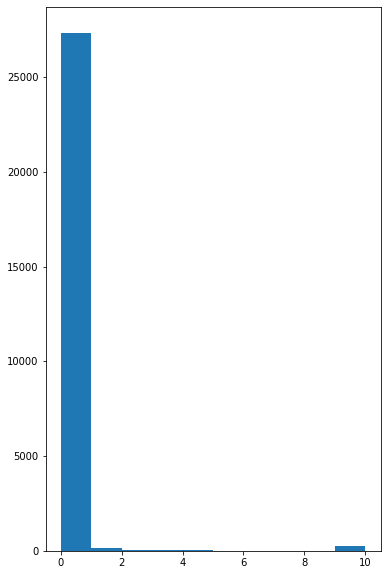

In [59]:
plt.figure(figsize=[6, 10])

plt.hist(data = loans_to_2008, x='DebtToIncomeRatio')

Ratios above 1 are very rare. I guess those people are in a bad way.

Since they owe more than they make in a year.

It is weird that the largest outlier is like 9 to 10. Are we to believe there are people who owe ten times what they make in a year? And Prosper still gave them loans??

Let's zoom in to 0 to 1 range to see what kind of variation there is there.

(0.0, 2.0)

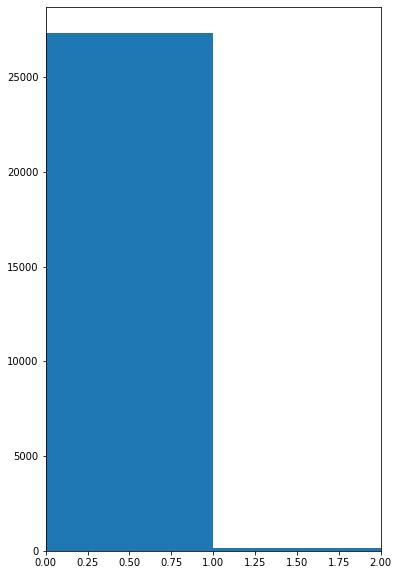

In [60]:
plt.figure(figsize=[6, 10])

plt.hist(data = loans_to_2008, x='DebtToIncomeRatio')

plt.xlim(0, 2)

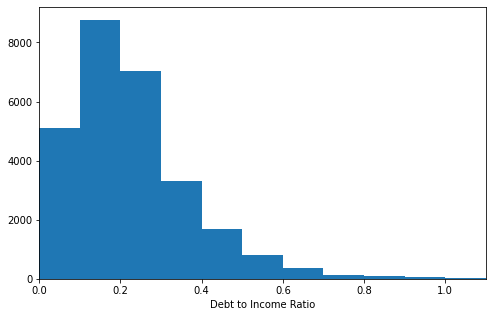

In [61]:
# I need to adjust the bin sizes

binsize = .1
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

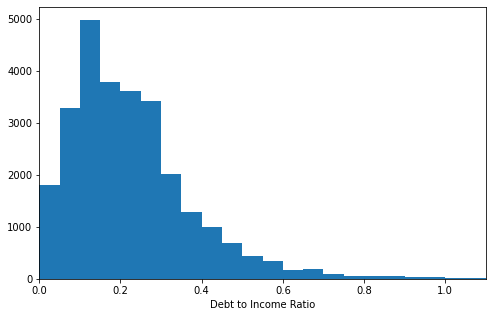

In [62]:

binsize = .05
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

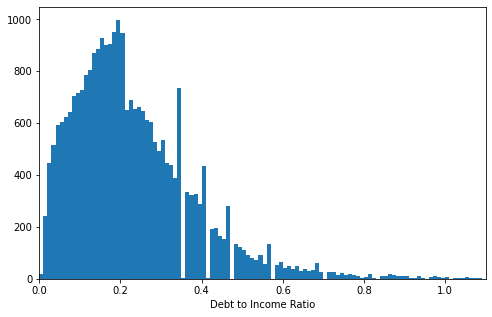

In [63]:
binsize = .01
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

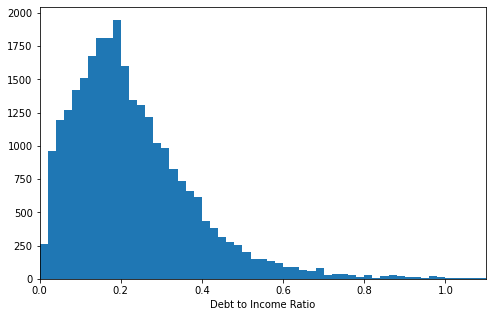

In [64]:
binsize = .02
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
#plt.xticks(rotation)
plt.xlim(0, 1.1)
plt.show()

See below a log transformation of the same data.

I don't see the advantage between that graph and one that zooms in on the 0 to 1 range and notes that there are a very few extreme outliers.

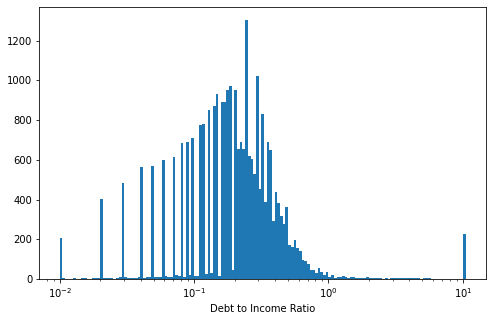

In [65]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .02
bins = 10**np.arange(-2, np.log10(loans_to_2008['DebtToIncomeRatio'].max())+binsize, binsize)

#x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
#plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

I don't think using a log transformation will help here.

It isn't just a long tale. It is a giant gap between fractions less than 1 and 10.

I fiddle around with the graph a little below, but the results are less satisfying than zooming in and noting that there are a very few outliers whose debts far exceed their incomes.

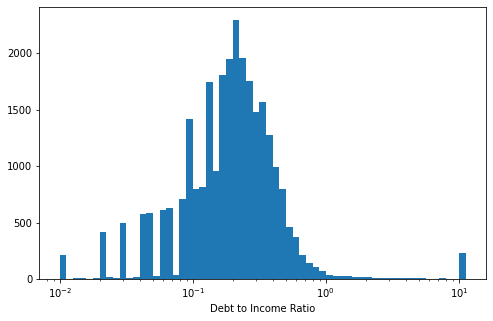

In [66]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .05
bins = 10**np.arange(-2, np.log10(loans_to_2008['DebtToIncomeRatio'].max())+binsize, binsize)

#x_tick_locs = np.array([.1, .3, .5, .7, 1, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
#plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

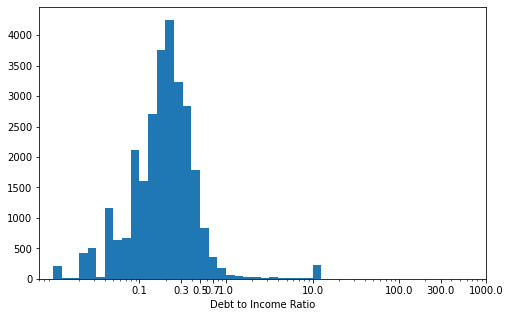

In [67]:
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

binsize = .1
bins = 10**np.arange(-2, np.log10(loans_to_2008['DebtToIncomeRatio'].max())+binsize, binsize)

x_tick_locs = np.array([.1, .3, .5, .7, 1, 10, 100, 300, 1000])

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'DebtToIncomeRatio', bins=bins)
plt.xlabel('Debt to Income Ratio')
plt.xscale('log')
plt.xticks(x_tick_locs, x_tick_locs)
#plt.xticks(rotation=45)

plt.show()

The vast majority of the loans are given to people who's debt-to-income ratio is less than 1.

Of those, there are many people with debt ratios from 0 to .1; but almost twice as many with ratios from .1 to .2; it tapers down from this height, with .3 having more loans than .1 but less than .2, and then a pretty quick drop-off.

This makes sense. Most people who need loans are exceeding their income at least somewhat, but you usually can't get a loan if you are exceeding your income by too much. I guess the bulk of lendees are living 20 to 30 percent above their incomes.

But who are these people that owe ten times what they make?

### Investigating Debt to Income Ratios programmatically

In [68]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] > 9].head(20)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
51,2EA63382419173023274969,104542,2007-02-28 10:45:44.153,D,36,Completed,2009-07-07 00:00:00,0.11749,0.1000,0.0900,...,0.00,0.00,0.00,1.0,0,0,0.0,16,Successful,0.111060
143,3C18338635952151669AA4C,124494,2007-04-16 17:44:06.780,AA,36,Completed,2007-06-28 00:00:00,0.10505,0.0935,0.0885,...,0.00,0.00,0.00,1.0,0,0,0.0,58,Successful,0.016200
304,029C3391969521662B80577,146341,2007-06-03 20:32:32.783,A,36,Completed,2010-05-25 00:00:00,0.11415,0.1072,0.0997,...,0.00,0.00,0.00,1.0,0,0,0.0,87,Successful,0.178200
462,02F1339019841280370DC32,139992,2007-05-19 11:14:54.370,A,36,Defaulted,2010-09-29 00:00:00,0.08684,0.0800,0.0650,...,34.60,-34.34,32.62,1.0,1,1,750.0,19,Unsuccessful,0.144523
546,7FF33379485792378896C12,91476,2007-01-31 14:16:07.313,C,36,Completed,2009-12-29 00:00:00,0.16436,0.1572,0.1472,...,0.00,0.00,0.00,1.0,0,0,0.0,179,Successful,0.240116
589,45B43387230086794000897,128885,2007-04-25 22:12:59.947,AA,36,Defaulted,2007-11-01 00:00:00,0.18726,0.1800,0.1750,...,3916.54,3916.54,0.00,1.0,0,0,0.0,90,Unsuccessful,-0.963422
664,426D33702731866796C69D2,47155,2006-10-11 11:33:03.480,B,36,Completed,2009-10-30 00:00:00,0.18224,0.1750,0.1650,...,0.00,0.00,0.00,1.0,0,0,0.0,72,Successful,0.292953
859,423A33896243107125B04BB,138087,2007-05-15 17:42:32.200,D,36,Chargedoff,2008-12-25 00:00:00,0.22744,0.2200,0.2100,...,2997.98,2997.98,0.00,1.0,0,0,0.0,52,Unsuccessful,-0.439931
1196,0EDB3387076244781A19AB4,126753,2007-04-21 10:11:30.990,AA,36,Completed,2007-08-02 00:00:00,0.08971,0.0725,0.0625,...,0.00,0.00,0.00,1.0,0,0,0.0,33,Successful,0.017990
1234,48D03387495590363EC0F0B,127212,2007-04-22 17:40:44.490,A,36,Defaulted,2009-05-01 00:00:00,0.18726,0.1800,0.1750,...,13455.94,13455.94,0.00,1.0,1,1,1200.0,401,Unsuccessful,-0.290808


In [69]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] > 9][["DebtToIncomeRatio", "CreditGrade", "IncomeRange", "ROI"]].head(30)

,DebtToIncomeRatio,CreditGrade,IncomeRange,ROI
51,10.01,D,Not displayed,0.111060
143,10.01,AA,"$1-24,999",0.016200
304,10.01,A,Not employed,0.178200
462,10.01,A,Not employed,0.144523
546,10.01,C,Not displayed,0.240116
589,10.01,AA,Not employed,-0.963422
664,10.01,B,Not displayed,0.292953
859,10.01,D,Not employed,-0.439931
1196,10.01,AA,"$1-24,999",0.017990
1234,10.01,A,"$1-24,999",-0.290808


In [70]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] > 9]["CreditGrade"].count()

228

In [71]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 9) & (loans_to_2008['DebtToIncomeRatio'] > 5)]["CreditGrade"].count()

25

In [72]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 5) & (loans_to_2008['DebtToIncomeRatio'] > 3)]["CreditGrade"].count()

44

In [73]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 3) & (loans_to_2008['DebtToIncomeRatio'] > 2)]["CreditGrade"].count()

42

In [74]:
loans_to_2008[(loans_to_2008['DebtToIncomeRatio'] < 2) & (loans_to_2008['DebtToIncomeRatio'] > 1)]["CreditGrade"].count()

135

In [75]:
loans_to_2008[loans_to_2008['DebtToIncomeRatio'] < 1].count()

ListingKey                     27317
ListingNumber                  27317
ListingCreationDate            27317
CreditGrade                    27212
Term                           27317
                               ...  
InvestmentFromFriendsCount     27317
InvestmentFromFriendsAmount    27317
Investors                      27317
NewLoanStatus                  27317
ROI                            27317
Length: 83, dtype: int64

In [76]:
# breaking the debt to income ratio variable into bins

binsize = .1
bins = np.arange(0, loans_to_2008['DebtToIncomeRatio'].max()+binsize, binsize)
bins=[round(x,1) for x in bins]
labels = [f'''{bins[i]} - {bins[i +1]}''' for i in range (len(bins) -1)]

loans_to_2008['dti_bins'] = pd.cut(loans_to_2008['DebtToIncomeRatio'], bins, labels=labels, include_lowest=True)

# try groupby again
loans_to_2008.groupby('dti_bins')['DebtToIncomeRatio'].count()

dti_bins
0.0 - 0.1      5800
0.1 - 0.2      8999
0.2 - 0.3      6085
0.3 - 0.4      3536
0.4 - 0.5      1543
               ... 
9.6 - 9.7         0
9.7 - 9.8         1
9.8 - 9.9         0
9.9 - 10.0        0
10.0 - 10.1     226
Name: DebtToIncomeRatio, Length: 101, dtype: int64

Almost all the DTIR are less than 1. The relatively few borrowers with debt to income ratios above 1 tend to be people with either no income or very low income. I think the best way to deal with this is to zoom in on the area of interest and note that there are a very few outliers at higher DTIRs, and that these outliers tend to be people with either no or very low income.

Who are these 226 people who have debts 10 times their incomes???

Let's remove the 226 and the one person with like 9.7 times as much debt as income.

And see what we get.

In [77]:
less_than_9 = loans_to_2008[loans_to_2008['DebtToIncomeRatio'] < 9].copy()

less_than_9.groupby('dti_bins')['DebtToIncomeRatio'].count().head(20)

dti_bins
0.0 - 0.1    5800
0.1 - 0.2    8999
0.2 - 0.3    6085
0.3 - 0.4    3536
0.4 - 0.5    1543
0.5 - 0.6     687
0.6 - 0.7     353
0.7 - 0.8     152
0.8 - 0.9     109
0.9 - 1.0      60
1.0 - 1.1      29
1.1 - 1.2      17
1.2 - 1.3      18
1.3 - 1.4      15
1.4 - 1.5      13
1.5 - 1.6      15
1.6 - 1.7       6
1.7 - 1.8       7
1.8 - 1.9       6
1.9 - 2.0       9
Name: DebtToIncomeRatio, dtype: int64

The vast majority of borrowers have a debt-to-income ratio between 0 and 1. And within that range, there is quite a bit of variety. Perhaps by throwing out the few people with much higher debt-to-income ratios (which possibly skews and confuses the trends), DTIR can be a useful metric for predicting loan outcomes.

### Amount Delinquent counts

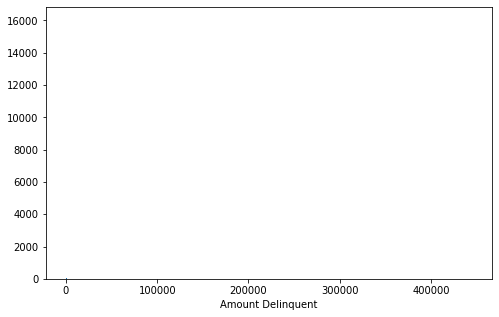

In [78]:
binsize = 25
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
#plt.xlim(0, 1000)
plt.show()

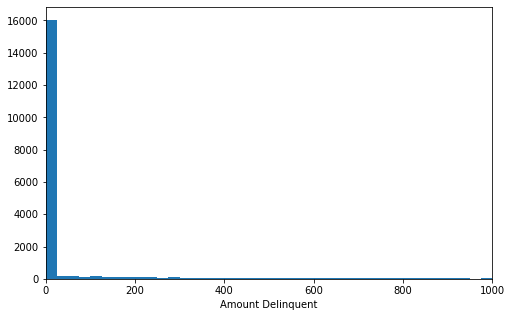

In [79]:
binsize = 25
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
plt.xlim(0, 1000)
plt.show()

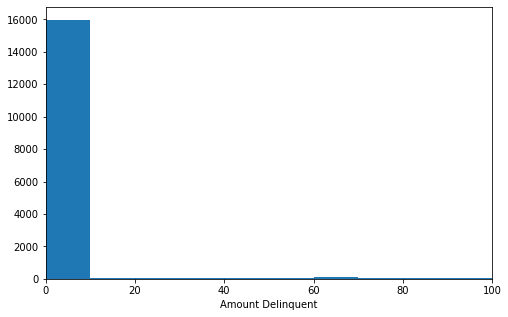

In [80]:
binsize = 10
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins = bins)
plt.xlabel('Amount Delinquent')
#plt.xticks(rotation)
plt.xlim(0, 100)
plt.show()

In [81]:
loans_to_2008.groupby('AmountDelinquent').count()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI,dti_bins
AmountDelinquent,,,,,,,,,,,,,,,,,,,,,
0.0,15944,15944,15944,15840,15944,15944,15944,15944,15944,15944,...,15944,15944,15944,15944,15944,15944,15944,15944,15944,14985
1.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
3.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160039.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
161344.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
161475.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [82]:
binsize = 10
# we have to exclude zero because many of the borrowers are $0 delinquent and pd.cut() can't handle zero
bins = np.arange(.1, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.1, 10.1]      38
(10.1, 20.1]     41
(20.1, 30.1]     58
(30.1, 40.1]     63
(40.1, 50.1]     66
(50.1, 60.1]     66
(60.1, 70.1]     76
(70.1, 80.1]     65
(80.1, 90.1]     54
(90.1, 100.1]    58
Name: AmountDelinquent, dtype: int64

In [83]:
binsize = 100
bins = np.arange(.1, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.1, 100.1]       585
(100.1, 200.1]     441
(200.1, 300.1]     365
(300.1, 400.1]     250
(400.1, 500.1]     196
(500.1, 600.1]     182
(600.1, 700.1]     171
(700.1, 800.1]     144
(800.1, 900.1]     131
(900.1, 1000.1]     96
Name: AmountDelinquent, dtype: int64

In [84]:
binsize = 1000
bins = np.arange(.1, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.1, 1000.1]        2561
(1000.1, 2000.1]      745
(2000.1, 3000.1]      443
(3000.1, 4000.1]      298
(4000.1, 5000.1]      217
(5000.1, 6000.1]      194
(6000.1, 7000.1]      143
(7000.1, 8000.1]      107
(8000.1, 9000.1]      101
(9000.1, 10000.1]      58
Name: AmountDelinquent, dtype: int64

In [85]:
binsize = 5000
bins = np.arange(0, loans_to_2008['AmountDelinquent'].max()+binsize, binsize)

dti_bins = pd.cut(loans_to_2008['AmountDelinquent'], bins)

# try groupby again
(loans_to_2008.groupby(dti_bins)['AmountDelinquent'].count()).head(10)

AmountDelinquent
(0.0, 5000.0]         4264
(5000.0, 10000.0]      603
(10000.0, 15000.0]     253
(15000.0, 20000.0]     128
(20000.0, 25000.0]      79
(25000.0, 30000.0]      49
(30000.0, 35000.0]      37
(35000.0, 40000.0]      15
(40000.0, 45000.0]       9
(45000.0, 50000.0]      10
Name: AmountDelinquent, dtype: int64

In [86]:
loans_to_2008.groupby('dti_bins')['AmountDelinquent'].count().sum()

20321

The Amount Delinquent has an insanely long and uniformly low tale.

Most all of the amounts are around $100 or less.

But there are some that are more than $30K

I will try a log transformation.

In [87]:
# what is the max value for the Amount Delinquent column?

loans_to_2008.groupby('AmountDelinquent').describe()

ListingNumber                                          \
                         count           mean            std       min   
AmountDelinquent                                                         
0.0                    15944.0  265256.862331   91082.353435   98299.0   
1.0                        2.0  205357.500000  107455.482003  129375.0   
2.0                        3.0  221115.333333   96350.843932  117039.0   
3.0                        3.0  216106.333333   92259.931088  123684.0   
4.0                        2.0  118920.500000   11988.995475  110443.0   
...                        ...            ...            ...       ...   
160039.0                   1.0  294353.000000            NaN  294353.0   
161344.0                   1.0  280043.000000            NaN  280043.0   
161475.0                   1.0  360169.000000            NaN  360169.0   
190585.0                   1.0  162383.000000            NaN  162383.0   
444745.0                   1.0  123103.000000            NaN  123103.0   

                                                               Term  \
                        25%       50%        75%       max    count   
AmountDelinquent                                                      
0.0               188328.50  278624.5  342952.25  414823.0  15944.0   
1.0               167366.25  205357.5  243348.75  281340.0      2.0   
2.0               178070.00  239101.0  273153.50  307206.0      3.0   
3.0               170058.00  216432.0  262317.50  308203.0      3.0   
4.0               114681.75  118920.5  123159.25  127398.0      2.0   
...                     ...       ...        ...       ...      ...   
160039.0          294353.00  294353.0  294353.00  294353.0      1.0   
161344.0          280043.00  280043.0  280043.00  280043.0      1.0   
161475.0          360169.00  360169.0  360169.00  360169.0      1.0   
190585.0          162383.00  162383.0  162383.00  162383.0      1.0   
444745.0          123103.00  123103.0  123103.00  123103.0      1.0   

                             ... Investors             ROI            \
                       mean  ...       75%    max    count      mean   
AmountDelinquent             ...                                       
0.0               35.998495  ...    209.25  913.0  15944.0  0.008028   
1.0               36.000000  ...     73.25   84.0      2.0  0.445563   
2.0               36.000000  ...    242.00  274.0      3.0  0.240855   
3.0               36.000000  ...     32.00   38.0      3.0 -0.246383   
4.0               36.000000  ...     66.25   76.0      2.0  0.236599   
...                     ...  ...       ...    ...      ...       ...   
160039.0          36.000000  ...     28.00   28.0      1.0 -0.585290   
161344.0          36.000000  ...     29.00   29.0      1.0  0.574885   
161475.0          36.000000  ...      1.00    1.0      1.0 -1.000000   
190585.0          36.000000  ...     80.00   80.0      1.0  0.388575   
444745.0          36.000000  ...     50.00   50.0      1.0 -0.707990   

                                                                              
                       std       min       25%       50%       75%       max  
AmountDelinquent                                                              
0.0               0.378535 -1.000000 -0.103129  0.132443  0.246540  1.005920  
1.0               0.120849  0.360110  0.402836  0.445563  0.488289  0.531016  
2.0               0.070708  0.177903  0.202604  0.227304  0.272331  0.317357  
3.0               0.458514 -0.697074 -0.479361 -0.261648 -0.021037  0.219573  
4.0               0.145521  0.133700  0.185150  0.236599  0.288049  0.339498  
...                    ...       ...       ...       ...       ...       ...  
160039.0               NaN -0.585290 -0.585290 -0.585290 -0.585290 -0.585290  
161344.0               NaN  0.574885  0.574885  0.574885  0.574885  0.574885  
161475.0               NaN -1.000000 -1.000000 -1.000000 -1.000000 -1.000000  
190585.0               NaN  

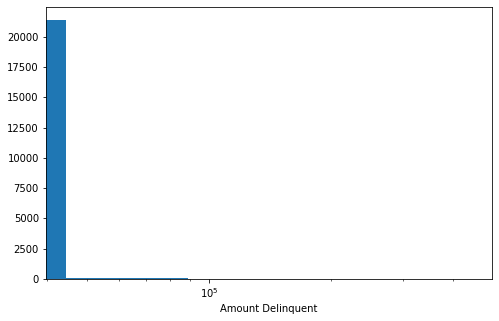

In [88]:
plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent')
plt.xscale('log')

plt.xlabel('Amount Delinquent')
plt.show()

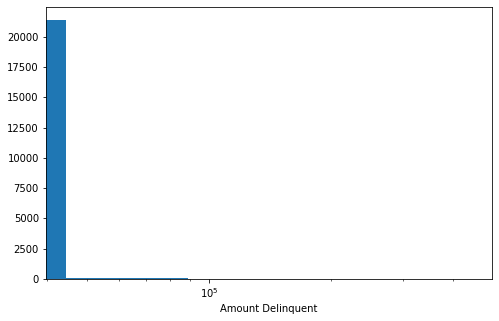

In [89]:
plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent')
plt.xscale('log')

plt.xlabel('Amount Delinquent')
plt.show()

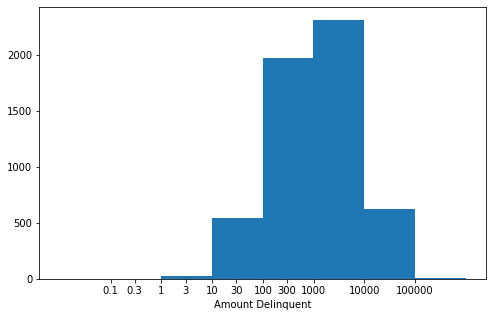

In [90]:
binsize = .999
bins = 10**np.arange(-2, np.log10(loans_to_2008['AmountDelinquent'].max())+binsize, binsize)

# Generate the x-ticks you want to apply
ticks = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 10000, 100000]
# Convert ticks into string values, to be displaye dlong the x-axis
labels = ['{}'.format(v) for v in ticks]

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins=bins)
plt.xscale('log')
plt.xticks(ticks, labels)

plt.xlabel('Amount Delinquent')
plt.show()

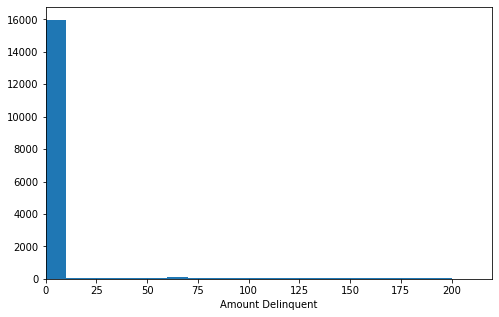

In [91]:
binsize = 10
bins = np.arange(0, 210, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'AmountDelinquent', bins=bins)
plt.xlim(0, 220)

plt.xlabel('Amount Delinquent')
plt.show()

The vast majority of borrows are //$0. After that, there is a wide distribution of values for Amount Delinquent.

A difficulty is that most Amount Delinquents are zero values, but log transformations can't handle zero values. 


In [92]:
# number of people who are not at all delinquent
loans_to_2008[loans_to_2008["AmountDelinquent"]==0].count()

ListingKey                     15944
ListingNumber                  15944
ListingCreationDate            15944
CreditGrade                    15840
Term                           15944
                               ...  
InvestmentFromFriendsAmount    15944
Investors                      15944
NewLoanStatus                  15944
ROI                            15944
dti_bins                       14985
Length: 84, dtype: int64

In [93]:
# of people with some delinquency

loans_to_2008[loans_to_2008["AmountDelinquent"]>0].count()

ListingKey                     5490
ListingNumber                  5490
ListingCreationDate            5490
CreditGrade                    5478
Term                           5490
                               ... 
InvestmentFromFriendsAmount    5490
Investors                      5490
NewLoanStatus                  5490
ROI                            5490
dti_bins                       5336
Length: 84, dtype: int64

See? 15,944 borrowers are \\$0 delinquent. 5,490 are to some degree delinquent. Perhaps if we broke this group into Delinquent and Not Delinquent, we would get a decent predictor value for loan completion (ie: maybe the delinquent borrowers are less likely to pay off this loan, too).

Let's look at three categorical values: IsBorrowerHomeowner, BorrowerState, Occupation

<AxesSubplot:>

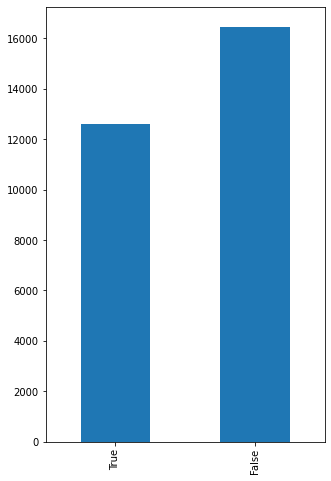

In [94]:
plt.figure(figsize=[5,8])

loans_to_2008['IsBorrowerHomeowner'].value_counts(sort=False).plot(kind='bar')

About 20% of the lenders owned homes than didn't.

<AxesSubplot:>

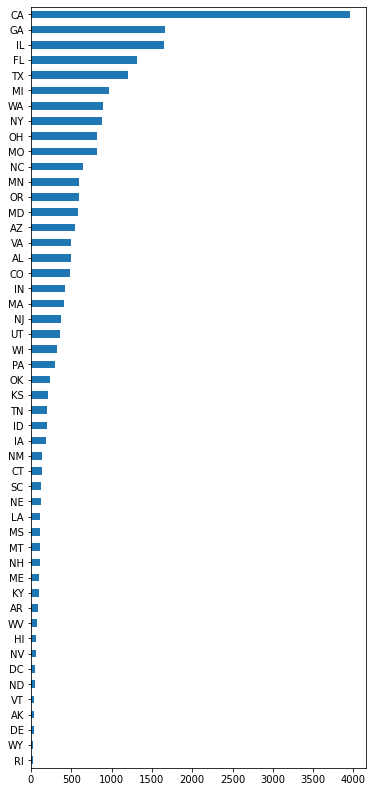

In [95]:
plt.figure(figsize=[6,14])

loans_to_2008['BorrowerState'].value_counts(sort=True, ascending=True).plot(kind='barh')

More than twice as many lenders were from CA than from the second highest ranking state (GA). CA is a very populous state. The numbers 3, 4, and 5 states are also very populous: IL, FL, TX. GA has a large population, but smaller than IL, FL, or TX. 

I looked up the most populous states.
https://www.statista.com/statistics/183497/population-in-the-federal-states-of-the-us/

Top 10 in Millions:

CA (39.7), TX (29.4), FL (21.7), NY (19.3), PA (12.8), IL (12.6), OH (11.7), GA (10.71), NC (10.6), MI (9.97)

Compare with the top 10 most lended-to (by Prosper 2005-2008):

CA, GA, IL, FL, TX, MI, WA, NY, OH, MO

Clearly factors besides the population of the state affect how many of its inhabitants took out a prosper loan, although many of the largest states also took out the most loans.

<AxesSubplot:>

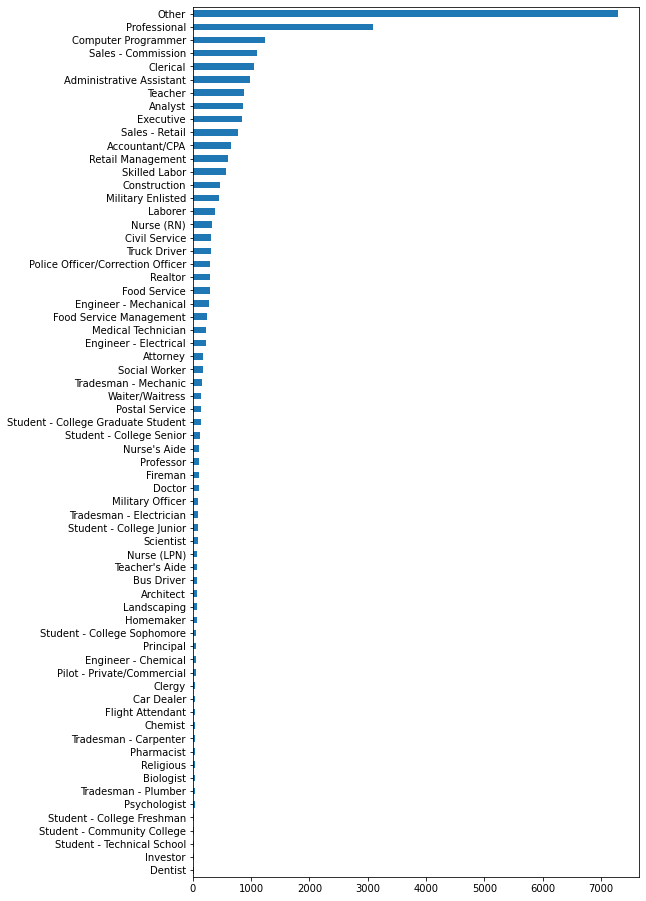

In [96]:
plt.figure(figsize=[8,16])

loans_to_2008['Occupation'].value_counts(sort=True, ascending=True).plot(kind='barh')

In [97]:
occupations = (loans_to_2008['Occupation'].value_counts(sort=True, ascending=False)).copy()
occupations.head(20)

Other                                7296
Professional                         3085
Computer Programmer                  1241
Sales - Commission                   1096
Clerical                             1047
Administrative Assistant              980
Teacher                               869
Analyst                               866
Executive                             843
Sales - Retail                        766
Accountant/CPA                        658
Retail Management                     601
Skilled Labor                         564
Construction                          464
Military Enlisted                     447
Laborer                               378
Nurse (RN)                            328
Civil Service                         317
Truck Driver                          308
Police Officer/Correction Officer     299
Name: Occupation, dtype: int64

I don't see how useful this can be. By far the biggest category is "Other" (7296), followed by the generic "Professional" (3085). After that, only Computer Programmer, Sales - Commission and Clerical break 1000.

#### Credit Score Range

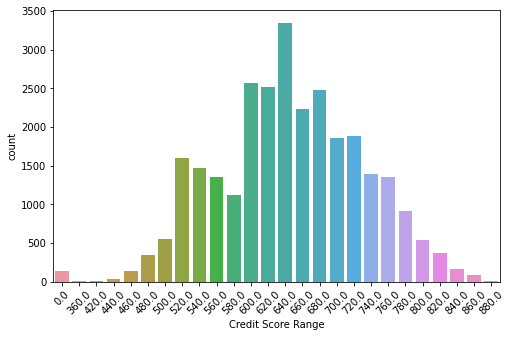

In [98]:
plt.figure(figsize=[8, 5])
sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeLower')
plt.xlabel('Credit Score Range')
plt.xticks(rotation=45);

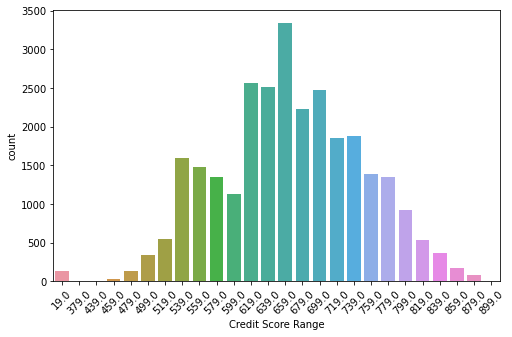

In [99]:
plt.figure(figsize=[8, 5])
sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeUpper')
plt.xlabel('Credit Score Range')
plt.xticks(rotation=45);

In [100]:
csru = pd.unique(loans_to_2008['CreditScoreRangeUpper'])
sorted(csru)

[19.0,
 379.0,
 439.0,
 459.0,
 479.0,
 499.0,
 519.0,
 539.0,
 559.0,
 579.0,
 599.0,
 619.0,
 639.0,
 659.0,
 679.0,
 699.0,
 719.0,
 739.0,
 759.0,
 779.0,
 799.0,
 819.0,
 839.0,
 859.0,
 nan,
 879.0,
 899.0]

In [101]:
loans_to_2008.CreditScoreRangeUpper.value_counts().sort_index()

19.0      133
379.0       1
439.0       5
459.0      36
479.0     141
499.0     346
519.0     554
539.0    1593
559.0    1474
579.0    1357
599.0    1125
619.0    2562
639.0    2517
659.0    3347
679.0    2229
699.0    2471
719.0    1855
739.0    1886
759.0    1391
779.0    1351
799.0     919
819.0     537
839.0     366
859.0     169
879.0      90
899.0      10
Name: CreditScoreRangeUpper, dtype: int64

Credit Score Range tends to look fairly bell-shaped. This is not true of the Credit Grades, whose population counts sloped gently downward as Credit Grade went down. Maybe I should examine the relationship between Credit Score Range and Credit Grade in the bivariate section. To see if I can understand why these apparently closely-related metrics have such different population-count graphs.

### When I decided to come up with the ROI metric

Earlier I calculated that the success rate for the loans studied here (loans made from 2005 through 2008), was about 63%. That seems like a terrible failure rate, but I didn't factor in how much money the loans that were eventually defaulted or charged off had already paid back to the lender.

I think a better metric for measuring the success of the loans would be something like: (Amount Lendee paid Lender) - (Amount of Loan + Amount spent by Lendee in quest to recover Loan).

To that end, I will create the following column:

return on investment = (payments.sum - servicefees.sum - collectionfees.sum - loanamount + nonprincipalrecovery.sum + principalrecovery.sum)/loanamount


In [102]:
loans_to_2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29056 entries, 0 to 29055
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           29056 non-null  object        
 1   ListingNumber                        29056 non-null  int64         
 2   ListingCreationDate                  29056 non-null  datetime64[ns]
 3   CreditGrade                          28940 non-null  category      
 4   Term                                 29056 non-null  int64         
 5   LoanStatus                           29056 non-null  object        
 6   ClosedDate                           29056 non-null  object        
 7   BorrowerAPR                          29031 non-null  float64       
 8   BorrowerRate                         29056 non-null  float64       
 9   LenderYield                          29056 non-null  float64       
 10  EstimatedE

In [103]:
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 
loans_to_2008.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI,dti_bins
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,0.00,0.00,1.0,0,0,0.0,258,Successful,0.223270,0.1 - 0.2
1,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,0.00,0.00,1.0,0,0,0.0,41,Successful,0.403142,0.0 - 0.1
2,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,0.00,0.00,1.0,0,0,0.0,53,Successful,0.012530,0.2 - 0.3
3,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Chargedoff,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,6012.67,268.96,1.0,0,0,0.0,85,Unsuccessful,-0.435110,0.1 - 0.2
4,1017340630713945364DA6B,241498,2007-11-30 20:33:49.227,D,36,Completed,2010-12-12 00:00:00,0.21488,0.2075,0.1975,...,0.00,0.00,1.0,0,0,0.0,53,Successful,0.370723,0.0 - 0.1


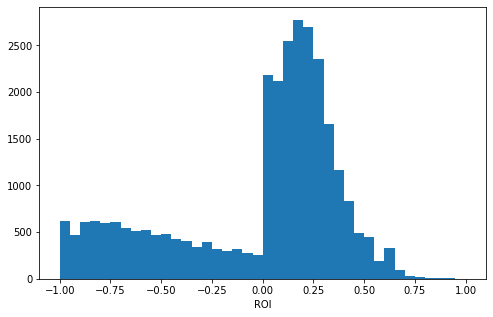

In [104]:
binsize = .05
bins = np.arange(-1.05, loans_to_2008['ROI'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins = bins)
plt.xlabel('ROI')
#plt.xticks(rotation)
plt.xlim(-1.1,1.1)
plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

My focus is on whether or not a loan was successful. 

I limited the loans to those begun on or prior to 2008, because I calculated that those loans should've been completed by well before the date that they stopped adding data to the dataframe. That way I can see what percentage of loans that should've been paid off were indeed paid off.

If the focus of the investigation is whether or not a loan should be completed, the most obvious variable of interest for LoanStatus.

However, of the four categories of LoanStatus that occur in the data prior to 2009, two (ChargedOff and Defaulted) seem to me to be clearly unsuccessful, and one (Completed) as clearly successful. One (Cancelled) I am not sure how to assess, and there only five rows in the entire dataset with this outcome. Accordingly, I created a new variable NewLoanStatus with two categories: Successful for Completed and Unsuccessful for ChargedOff and Defaulted.

This is the breakdown for each category:

Completed - 18385 / Chargedoff - 6654 / Defaulted - 4012 / Cancelled - 5

Which results in:

Successful - 18,385 / Unsuccessful - 10664 / Total - 29,056

That's a success rate of 18385/29056 = 63%

I would've thought the success rate would be much higher than that.

How can a lender stay in business with this kind of a success rate?

The graph was of course straight-forward. There was no need for transformations.

But I soon began to doubt that this categorization into Successful and Unsuccessful loans was an adequate metric for analyzing the success of the loans. For one thing, these calculations don't account for how much money was recovered in the "Unsuccessful" loans. Both a loan that paid the principal and a small portion of the interest and a loan that didn't pay anything at all would be labelled "Unsuccessfull", but the former hypothetical loan is much more successful than the latter one.

So I decided to look at return on investment, calculated like this:

loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 


With that metric, I saw that the bulk of the loans had an ROI between 0+ (a touch above 0)  and .3,and then tapered down to .75, with only a very few loans doing better than that on the positive side. The negative side had much less values, but they were much more uniform than the positive values. About 250 loans had an ROI of 0, and then the trend is a gradual slope upward until -1, where there are about 500 loans that I guess you could characterize as complete disasters (ie: an ROI of -1, and thus a loss of all the money lent).

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Income Range: Nothing shocking here. By far the most loans went to people making between \\$25K and \\$50K; with the \\$50K to \\$75K range accounting for about 3/4 as many borrowers as the \\$25-\\$50K range, and the two groups of those making more and the one group of those making less than \\$25-\\$75k each accounting for about 1/4 as many loans as the \\$25-\\$50K group. So people with low to medium incomes accounted for the most loans, which isn't surprising. A lot of people fall into this category and their expenditures often drift beyond their incomes. The graph was straight forward. No transforamtions were needed.

Debt To Income: Values generally between 0 and 1. The best graph was at bin sizes of .02. Right skewed, concave to the right, convex to the left. A fairly long tail, but I didn't see a reason to do a log transformation -- the values (between 0 and 1.5) seemed too circumstribed for that. The highpoint was around .2, and there was a lot more variety to the values greater than .2 than to the values less than .2  A couple hundred borrowers had extremely high debt-to-income ratios. These tended to be people with either no income or a very low one. To use this as a predictor variable, it would perhaps be wise to throw these extremely high debt to incomes out -- since they are a statistically insignificant number of them, and the magnitude of this DTI is so many times greater than the typical DTI (I fear these relatively few extremely high DTIs could obscure the true trends in the data).

Amount Delinquent: I did a log transformation since it had such a long tale. There was a fairly bell-shaped curve after the log transformation, with the bottom values close to zero and the top values around \\$100K. HOWEVER, to do a log transformation, I had to skip over those who were $0 delinquent, and they account for 2/3 of the total. Therefore, if I use this log transform in a presentation, I'd have to name it something like "Amount Delinquent (excluding those who owed \\$0)" and then prominently explain that they constitute the majority of the cases.

Credit Grade: Straight-forward graphs. At first, I was surprised at how many loans they gave to people with lower credit raitings. C was the most common rating, but D was almost as common as C, and there were a lot of loans given to people with even lower credit ratings. But then I decided that actually correlated well with the income range distribution: the better credit ratings probably went to the relatively few people at the higher income ranges.

Borrower State: Pretty straightforward graphs. I was surprised a little by the states that had the most borrowers. California had by far the most. That wasn't too surprising, since it is such a populous state. But the second most borrowers were in Georgia, and then Illinois. Those are large states, but Georgia particularly is nowhere near number 2 in population. I guess this has somethign to do with the states where Prosper had the largest presence during the time period we're analysing.

Occupation: I don't know how useful this one can be. By far the largest category is "Other" \\$7K+), and then the very vague "Professional" (\\$3K+). Then there are only three with at least \\$1K, and one of them is the still very vague "Clerical".

Home Owner: Straight forward. There's about 20% people who don't own homes than who do.

## Bivariate Exploration

>Here we will investigate the relationships between the two possible loan-succes metrics (ROI and NewLoanStatus) and the several possible predictor variables (AmountDelinquent, DebtToIncomeRatio, StatedMonthlyIncome, the several credit grade/score variables, BorrowState, Occupation, and IsBorrowerHomeOwner). 

>As previously mentioned, we will restrict our investigations to predictor variables about the borrowers (so we won't include variables like APR, or other details of the loans). We are trying to see how characteristics of the lenders make the loans more or less likely to succeed. 

First I will organize the predictor variables by variable type -- if for no other reason than to help myself think about them more systematically.

In [105]:
numeric_vars = ['AmountDelinquent', 'StatedMonthlyIncom', 'CreditScoreRangeUpper', 'CreditScoreRangeLower']
percent_vars = ['DebtToIncomeRatio']
ordinal_vars = ['CreditGrade', 'IncomeRange']
nominal_vars = ['BorrowerState', 'Occupation']
binary_vars = ['IsBorrowerHomeowner', 'EmploymentStatus']


### Debt to Income Ratio vs ROI

Text(0.5, 1.0, 'Debt to Income Ratio VS ROI')

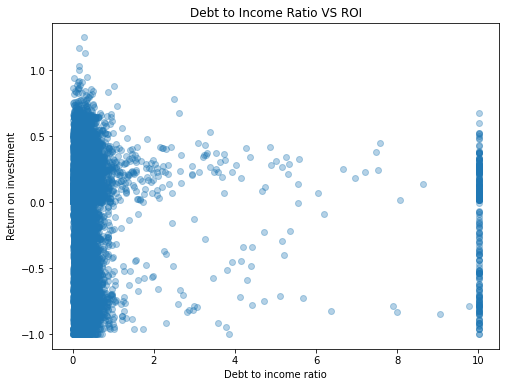

In [106]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'DebtToIncomeRatio', y = 'ROI', alpha=1/3)
plt.xlabel('Debt to income ratio')
plt.ylabel('Return on investment')
plt.title('Debt to Income Ratio VS ROI')


This tells me nothing. Most of the debt to income ratio's are less than one; and the most of those ROIs ranges from -1 to .75. The DTIR bump out past 1 from 0 to .5 and taper inward after that, shutting off around .75. It is a little surprising that higher ROIs seem to be correlated with slightly higher DTIR.

I will adjust the plot-points to see if I can see more info.

([<matplotlib.axis.XTick at 0x7ee71d7935c0>,
 [Text(0.0, 0, '0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10')])

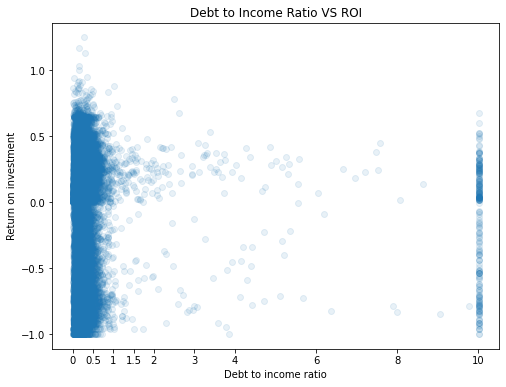

In [107]:
plt.figure(figsize = [8, 6])
xticks = [0,.5,1,1.5,2, 3, 4, 6, 8,10]
plt.scatter(data = loans_to_2008, x = 'DebtToIncomeRatio', y = 'ROI', alpha=1/10)
plt.xlabel('Debt to income ratio')
plt.ylabel('Return on investment')
plt.title('Debt to Income Ratio VS ROI')
plt.xticks(xticks, xticks)

Still pretty much a tower. The vast majority of the DTIR is between 0 and .75. You can see a little bulge outward (higher DtIs) as the ROIs start becoming postitive. That bump peaks at about 1 DTIR with a ROI of about .25, and then gradually sinks back to a DTI of about .75 at an ROI of .5, and holds steady with the DTIR though about .7 ROI

And everything else is an outlier.

I'll try once more, adding jitter.

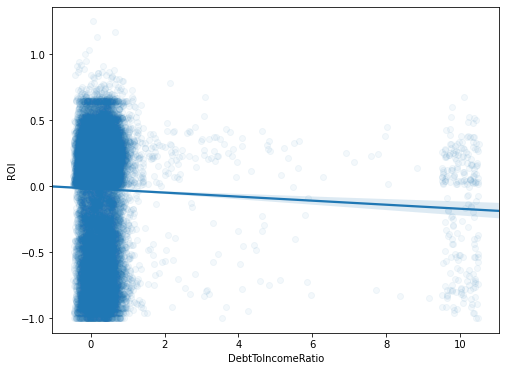

In [108]:
plt.figure(figsize = [8, 6])
sb.regplot(data = loans_to_2008, x = 'DebtToIncomeRatio', y = 'ROI', truncate=False, x_jitter=0.5, scatter_kws={'alpha':1/20});

Still not very interesting. Almost all DTIR values are within the same range, and they lead to the same results. It doesn't look like DTIR is a very good predictor value.

Let's run it through a correlation function.

In [109]:
roi_dtir = loans_to_2008[['DebtToIncomeRatio', 'ROI']].copy()
roi_dtir.corr(method='pearson')

,DebtToIncomeRatio,ROI
DebtToIncomeRatio,1.000000,-0.034124
ROI,-0.034124,1.000000


In [110]:
roi_dtir.corr(method='spearman')

,DebtToIncomeRatio,ROI
DebtToIncomeRatio,1.000000,0.023919
ROI,0.023919,1.000000


-.034 is not a very significant correlation.

I'll just check the pearson score after removing the outliers real quick and then stop investigating this variable.

In [111]:
less_than_3 = (loans_to_2008[loans_to_2008['DebtToIncomeRatio'] <3]).copy()

In [112]:
roi_dtir_2 = less_than_3[['DebtToIncomeRatio', 'ROI']].copy()

In [113]:
roi_dtir_2.corr(method='pearson')

,DebtToIncomeRatio,ROI
DebtToIncomeRatio,1.000000,-0.021871
ROI,-0.021871,1.000000


Still not a meaningful correlation.

In [114]:
less_than_1 = (loans_to_2008[loans_to_2008['DebtToIncomeRatio'] < 1]).copy()
roi_dtir_1 = less_than_1[['DebtToIncomeRatio', 'ROI']].copy()
roi_dtir_1.corr(method='pearson')

,DebtToIncomeRatio,ROI
DebtToIncomeRatio,1.000000,-0.028312
ROI,-0.028312,1.000000


OK, so even if we remove the outliers, DTI doesn't seem to be a very good predictor of ROI.

### A little more on DTIR and ROI -- please skip down to AmountDelinquent.

In [115]:
dtir_10 = (loans_to_2008[loans_to_2008.DebtToIncomeRatio >= 9]).copy()
dtir_10.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI,dti_bins
51,2EA63382419173023274969,104542,2007-02-28 10:45:44.153,D,36,Completed,2009-07-07 00:00:00,0.11749,0.1000,0.0900,...,0.00,0.00,1.0,0,0,0.0,16,Successful,0.111060,10.0 - 10.1
143,3C18338635952151669AA4C,124494,2007-04-16 17:44:06.780,AA,36,Completed,2007-06-28 00:00:00,0.10505,0.0935,0.0885,...,0.00,0.00,1.0,0,0,0.0,58,Successful,0.016200,10.0 - 10.1
304,029C3391969521662B80577,146341,2007-06-03 20:32:32.783,A,36,Completed,2010-05-25 00:00:00,0.11415,0.1072,0.0997,...,0.00,0.00,1.0,0,0,0.0,87,Successful,0.178200,10.0 - 10.1
462,02F1339019841280370DC32,139992,2007-05-19 11:14:54.370,A,36,Defaulted,2010-09-29 00:00:00,0.08684,0.0800,0.0650,...,-34.34,32.62,1.0,1,1,750.0,19,Unsuccessful,0.144523,10.0 - 10.1
546,7FF33379485792378896C12,91476,2007-01-31 14:16:07.313,C,36,Completed,2009-12-29 00:00:00,0.16436,0.1572,0.1472,...,0.00,0.00,1.0,0,0,0.0,179,Successful,0.240116,10.0 - 10.1


Text(0.5, 1.0, 'Debt to Income Ratio VS ROI')

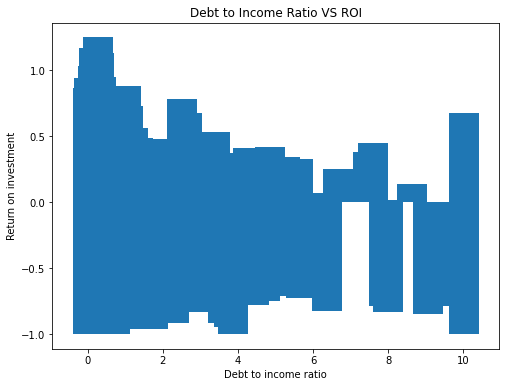

In [116]:
plt.figure(figsize = [8, 6])

plt.bar(data = loans_to_2008, x = 'DebtToIncomeRatio', height = 'ROI')
plt.xlabel('Debt to income ratio')
plt.ylabel('Return on investment')
plt.title('Debt to Income Ratio VS ROI')
#plt.ylim(-1.1, 1)

In [117]:
dtir = (loans_to_2008.groupby('DebtToIncomeRatio').mean()).copy()
dtir.ROI.head(40)

DebtToIncomeRatio
0.00000   -0.179402
0.00044    0.023433
0.00310   -0.974264
0.00611    0.122210
0.00647   -0.965610
0.00677    0.023290
0.00722    0.395710
0.01000    0.004224
0.01042   -0.839210
0.01051    0.000660
0.01087   -0.963565
0.01091   -0.030300
0.01115    0.102820
0.01138    0.242240
0.01234    0.031456
0.01275    0.140530
0.01289    0.017790
0.01303    0.023340
0.01315   -0.391612
0.01330    0.142610
0.01371   -0.757485
0.01404    0.000353
0.01459    0.173960
0.01482    0.055083
0.01504   -1.000000
0.01510    0.000440
0.01523    0.133968
0.01539   -0.545270
0.01544    0.423142
0.01581    0.153097
0.01609    0.128728
0.01663    0.125340
0.01719    0.004076
0.01747    0.011613
0.01783    0.004370
0.01784    0.328670
0.01825    0.072683
0.01853    0.242973
0.01876    0.069083
0.01877    0.434100
Name: ROI, dtype: float64

In [118]:
dtir.ROI.head()

DebtToIncomeRatio
0.00000   -0.179402
0.00044    0.023433
0.00310   -0.974264
0.00611    0.122210
0.00647   -0.965610
Name: ROI, dtype: float64

In [119]:
loans_to_2008.DebtToIncomeRatio.describe()

count    27799.000000
mean         0.323973
std          0.931787
min          0.000000
25%          0.120000
50%          0.200000
75%          0.300000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

In [120]:
# bins for debt to income ratio
# bin edges will be minimum, 25%, 50%, 75%, and max values
bin_edges = [0, .12, .2, .3, 10.01]
bin_names = ["LowDTIR", "MediumLowDTR", "MediumHighDTR", "HighDTR"]
# make a column of retweet levels
loans_to_2008["DTIRLevels"] = pd.cut(loans_to_2008['DebtToIncomeRatio'], bin_edges, labels=bin_names)
loans_to_2008.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI,dti_bins,DTIRLevels
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,0.00,1.0,0,0,0.0,258,Successful,0.223270,0.1 - 0.2,MediumLowDTR
1,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,0.00,1.0,0,0,0.0,41,Successful,0.403142,0.0 - 0.1,LowDTIR
2,0F1734025150298088A5F2B,213551,2007-10-09 20:28:33.640,C,36,Completed,2008-01-07 00:00:00,0.15033,0.1325,0.1225,...,0.00,1.0,0,0,0.0,53,Successful,0.012530,0.2 - 0.3,MediumHighDTR
3,0FDF336575182398852A8DC,31540,2006-08-15 12:21:09.433,AA,36,Chargedoff,2008-05-22 00:00:00,0.13202,0.1250,0.1175,...,268.96,1.0,0,0,0.0,85,Unsuccessful,-0.435110,0.1 - 0.2,LowDTIR
4,1017340630713945364DA6B,241498,2007-11-30 20:33:49.227,D,36,Completed,2010-12-12 00:00:00,0.21488,0.2075,0.1975,...,0.00,1.0,0,0,0.0,53,Successful,0.370723,0.0 - 0.1,LowDTIR


In [121]:
dtir_levels = (loans_to_2008.groupby('DTIRLevels').mean()).copy()

In [122]:
dtir_levels.ROI

DTIRLevels
LowDTIR         -0.024026
MediumLowDTR    -0.009126
MediumHighDTR   -0.013603
HighDTR         -0.043563
Name: ROI, dtype: float64

### Amount Delinquent vs ROI

Text(0.5, 1.0, 'Amount Delinquent VS ROI')

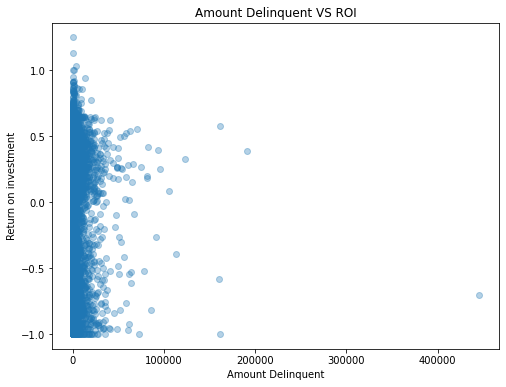

In [123]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'AmountDelinquent', y = 'ROI', alpha=1/3)
plt.xlabel('Amount Delinquent')
plt.ylabel('Return on investment')
plt.title('Amount Delinquent VS ROI')

(-1.0, 50000.0)

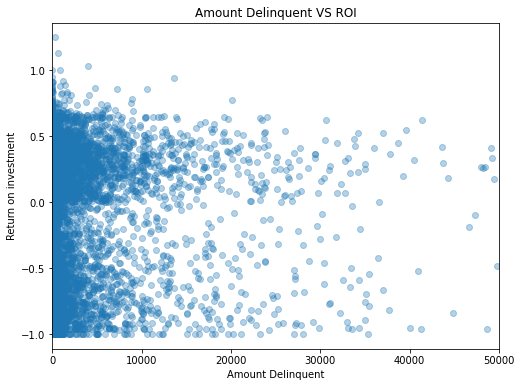

In [124]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'AmountDelinquent', y = 'ROI', alpha=1/3)
plt.xlabel('Amount Delinquent')
plt.ylabel('Return on investment')
plt.title('Amount Delinquent VS ROI')
plt.xlim(-1, 50000)

This also doesn't look like a very useful metric. I'll run it through the correlation function real quick.

In [125]:
ad_roi = loans_to_2008[['AmountDelinquent', 'ROI']].copy()
ad_roi.corr(method='pearson')

,AmountDelinquent,ROI
AmountDelinquent,1.000000,-0.041555
ROI,-0.041555,1.000000


In [126]:
ad_roi.corr(method='spearman')

,AmountDelinquent,ROI
AmountDelinquent,1.000000,0.010643
ROI,0.010643,1.000000


This isn't a significant correlation. A small pearson correlation is from |.1| to |.3|

This isn't even very close to |.1|

Let's just see what happens if we remove the outliers.

In [127]:
ad_lt20 = loans_to_2008[loans_to_2008['AmountDelinquent'] < 10000].copy()
adlt20_roi = ad_lt20[['AmountDelinquent', 'ROI']].copy()
adlt20_roi.corr(method='pearson')

,AmountDelinquent,ROI
AmountDelinquent,1.00000,-0.04161
ROI,-0.04161,1.00000


In [128]:
adlt20_roi.corr(method='spearman')

,AmountDelinquent,ROI
AmountDelinquent,1.000000,0.016854
ROI,0.016854,1.000000


Still not even a small correlation.

### Ordinal Variables: Credit Grade & Income Range

Now I'll look at the two ordinal variables. CreditGrade & IncomeRange

First I'll see how they relate to each other.

Then I'll compare them to ROI.

In [129]:
# as an exercise, I'll turn these ordinal variables into categories computationally.

# convert CreditGrade and IncomeRange into ordered categorical types
ordinal_var_dict = {'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC'],
                    'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans_to_2008[var] = loans_to_2008[var].astype(ordered_var)
    
# I removed this one because it shouldn't be ordinal
#'CreditScoreRangeUpper': ['19.0', '379.0', '439.0', '459.0', '479.0', '499.0', '519.0', '539.0', '559.0', '579.0', '599.0', '619.0', '639.0','659.0', '679.0', '699.0', '719.0', '739.0', '759.0', '779.0', '799.0', '819.0', '839.0', '859.0', '879.0', '899.0', 'nan'

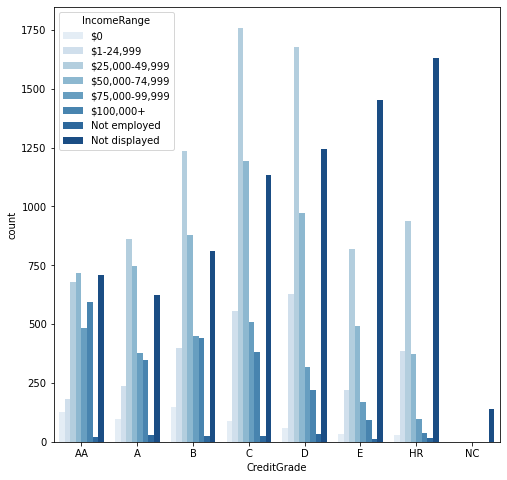

In [130]:

plt.figure(figsize = [8, 8])

# subplot 1: CreditGrade vs IncomeRange

sb.countplot(data = loans_to_2008, x = 'CreditGrade', hue = 'IncomeRange', palette = 'Blues')
plt.show()

I think this would be more meaningful if I had the percent of each income range in each credit rating.

I'll try a barplot. But that won't work if both variables are categorical. I'll try StatedMonthlyIncome instead.

<AxesSubplot:xlabel='CreditGrade', ylabel='StatedMonthlyIncome'>

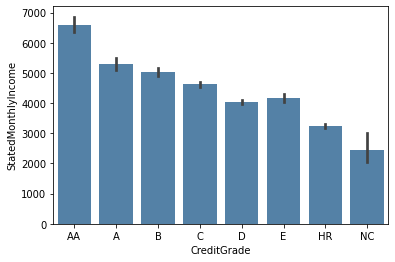

In [131]:
sb.barplot(x="CreditGrade", y="StatedMonthlyIncome", color='steelblue', data=loans_to_2008)

That makes sense. For AA, the incomes are quite a bit higher than the rest. Then from A to B and C there is a gradual slope, dropping off more for C to D. And then for some reason a little bit up for E.

I should check to see how StatedMonthlyIncome relates to IncomeRange.

##### Stated Monthly Income versus Income Range

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '$0'),
  Text(1, 0, '$1-24,999'),
  Text(2, 0, '$25,000-49,999'),
  Text(3, 0, '$50,000-74,999'),
  Text(4, 0, '$75,000-99,999'),
  Text(5, 0, '$100,000+'),
  Text(6, 0, 'Not employed'),
  Text(7, 0, 'Not displayed')])

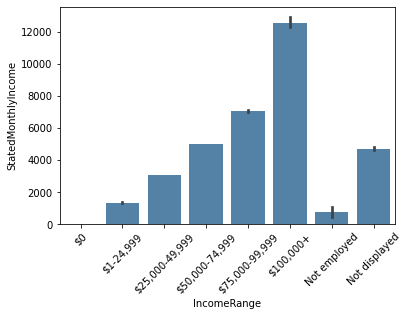

In [132]:
sb.barplot(x="IncomeRange", y="StatedMonthlyIncome", color='steelblue', data=loans_to_2008)
plt.xticks(rotation=45)

Correlated very linearly up through the \\$ 75&ndash; \\$99,9999 range.

The more drastic slope from that category up to the \\$100K+ category is also predictable -- because of the + at the end of the \\$100.

So we should be able to use IncomeRange and StatedMonthlyIncome interchangeably.

Let's compare ROI with these CreditRange, IncomeRange, and StatedMonthlyIncome.

### CreditGrade vs ROI and IncomeRange vs ROI

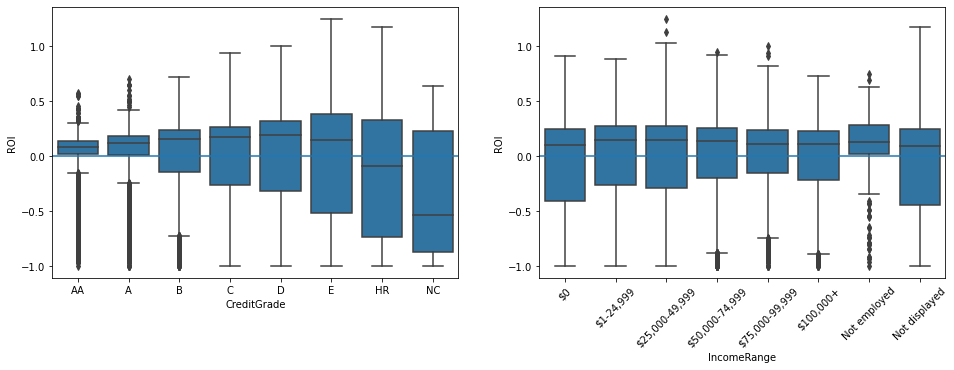

In [133]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

# LEFT plot: credit grade vs roi
plt.subplot(1, 2, 1)
sb.boxplot(data=loans_to_2008, x='CreditGrade', y='ROI', color=base_color);
plt.axhline(0)

# RIGHT plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data=loans_to_2008, x='IncomeRange', y='ROI', color=base_color)
plt.axhline(0)
plt.xticks(rotation=45);


What does it mean that median ROI goes slightly up from AA through D? 

It makes sense that the bottom 25% of ROIs should be longer and longer (starting with lower and lower values) as the credit grades decrease: more and more loans are performing poorly.

Why does the top 25% of ROIs tend to be concentrated in a small range of values in all grades from AA through D?

What does it mean that median ROI is pretty steady across all income levels, with only slight dips registering for $0 and Not Employed?

Roughly, the bottom 25% of values increases as we move away from the \\$75K-\\$99K income range (for 2008 a high but not very high income).

Excepting "Not Employed", all income ranges have lower quartiles significantly larger than their upper quartiles. 

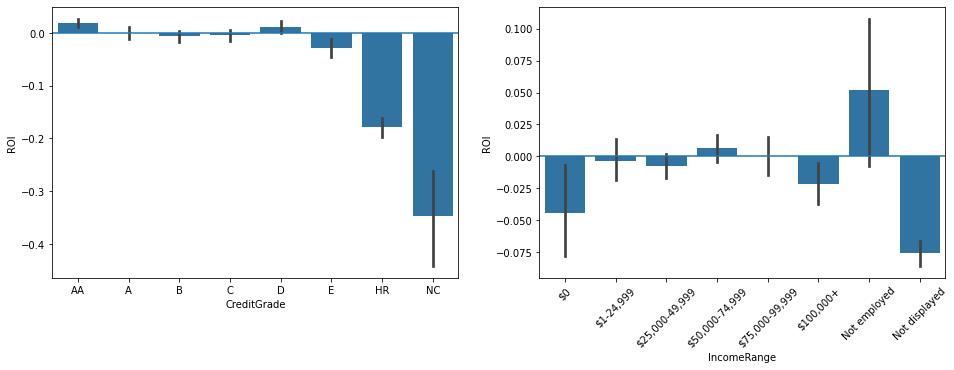

In [134]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

# LEFT plot: credit grade vs roi
plt.subplot(1, 2, 1)
sb.barplot(data=loans_to_2008, x='CreditGrade', y='ROI', color=base_color);
plt.axhline(0)

# RIGHT plot: box plot
plt.subplot(1, 2, 2)
sb.barplot(data=loans_to_2008, x='IncomeRange', y='ROI', color=base_color)
plt.axhline(0)
plt.xticks(rotation=45);

These are sorry sights. 

On average, AA and (to a lesser extent) D showed slight profits. A seems to have made \\$0. B and C lost a little money on average. HR (what is that?) and No Credit Grade both show a substantial average loss. 

These outcomes seem quite poor. The most loans given were Cs, followed closely by Ds, and then Bs. Cs have a very slight negative average, but with error bars into the positive range; Ds have a slight positive average, but with error bars into the negative range. The picture is of profits hovering around and generally dipping below zero. Only AA had a solidly positive ROI (with error bars above 0); but there were as many HR as AA loans given out, and HR loans have an ROI of close to -20 percent. Does this graph reflect difficult years from 2005 through 2008? Due to the 2007-2008 financial crisis, and their pre-2009 practices?

Here is the number of loans at each category during the 2005-2008 period:

C 5644  /  D 5151  /  B 4386  /  HR 3508  /  AA 3508  /  A 3313  /  E 3289 / NC 141

I found this from Wikipedia:

"
...
From 2006 to 2009 Prosper operated a variable rate model. Prosper acted as an eBay-style online auction marketplace, with lenders and borrowers ultimately determining loan rates using a Dutch auction-like system.
...
On November 24, 2008, the SEC found Prosper to be in violation of the Securities Act of 1933. As a result of these findings, the SEC imposed a cease and desist order on Prosper. Due primarily to the novel nature of the peer-to-peer lending models, the SEC, after review, now treats all peer-to-peer lending transactions as sales of securities and requires that all platforms register with the SEC.
...
As of August 2008, approximately 18.5% of all money loaned through Prosper from inception (February 2006) through June 2008 were in some form of delinquency. Also, more than 35% of all loans that originated in February 2007 were in some form of delinquency.
...
After Prosper's relaunch in July 2009, and implementing stricter credit guidelines for borrowers[20] Prosper's loan default rate has been significantly reduced. 
...
"

If we are considering Credit Grade as a predictor variable for ROI, the downward slope from AA through B is encouraging, but then the ROI increase slightly from B to C and from C to D. If CG was to be a good predictor variable for ROI, we'd expect the average ROI values to decrease or increase steadily in one direction as credit scores increase or decrease.

On average, loans made to people of all income ranges lost money, with two exceptions: \\$50K-\\$74,999 had a slight increase in average ROI, and \\$75K-\\$99,999 had a net ROI of about $0. As with Credit Grade and ROI, it is difficult to discern much of a pattern when trying to use ROI as a function of Income Range.

In [135]:
loans_to_2008.groupby('CreditGrade').count()

,ListingKey,ListingNumber,ListingCreationDate,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,...,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI,dti_bins,DTIRLevels
CreditGrade,,,,,,,,,,,,,,,,,,,,,
AA,3508,3508,3508,3508,3508,3508,3494,3508,3508,0,...,3508,3508,3508,3508,3508,3508,3508,3508,3247,3240
A,3313,3313,3313,3313,3313,3313,3312,3313,3313,0,...,3313,3313,3313,3313,3313,3313,3313,3313,3123,3123
B,4386,4386,4386,4386,4386,4386,4384,4386,4386,0,...,4386,4386,4386,4386,4386,4386,4386,4386,4105,4104
C,5644,5644,5644,5644,5644,5644,5641,5644,5644,0,...,5644,5644,5644,5644,5644,5644,5644,5644,5473,5472
D,5151,5151,5151,5151,5151,5151,5150,5151,5151,0,...,5151,5151,5151,5151,5151,5151,5151,5151,5021,5021
E,3289,3289,3289,3289,3289,3289,3288,3289,3289,0,...,3289,3289,3289,3289,3289,3289,3289,3289,3219,3218
HR,3508,3508,3508,3508,3508,3508,3506,3508,3508,0,...,3508,3508,3508,3508,3508,3508,3508,3508,3425,3423
NC,141,141,141,141,141,141,140,141,141,0,...,141,141,141,141,141,141,141,141,80,79


Let's look at CreditGrade and Income Ranges vs ROI on violin plots.

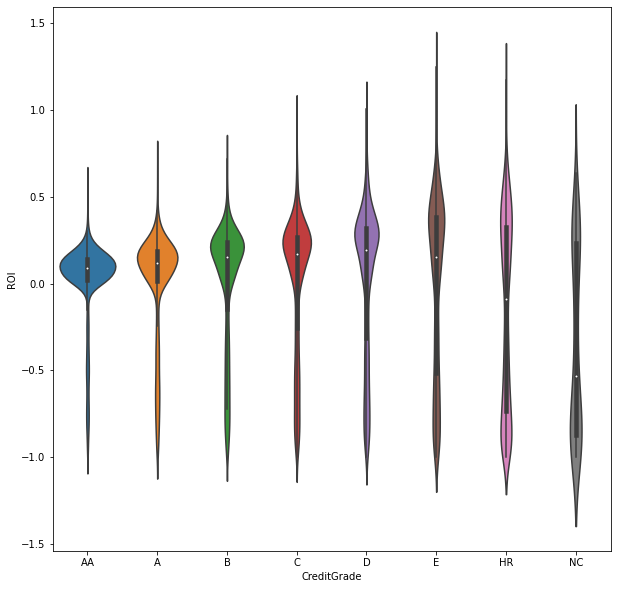

In [136]:
plt.figure(figsize = [10,10])
sb.violinplot(data=loans_to_2008, x='CreditGrade', y='ROI');

As credit grade goes down, the tendency is to get more variety in the outcomes.

I'm guessing that this tendency, as well as the larger bottom quartiles shown in the box plots, can be attributed to the higher level of risk in loans given to people with lower credit scores. More loans fail, and there are also more spectacular failures (ie: the lender recovered very little of the lent money), but those loans that succeed tend to have higher interest rates (since people with lower credit scores are charged more interest), making for higher ROIs for the successful loans. 

Both the violin plots and the box plots showed definite trends as Credit Grade increased. What does this mean? Credit Grade doesn't seem to be a very good predictor of average ROI success (at least not in this time period), but it seems to be a pretty good predictor of the overal statistical spread of the outcomes. I think maybe this is because the increasing medians and lengthening distribution bands offset each other, thus prevent the trends we can see in the violin and box plots from being seen in the average ROI scores (which is what the bar plot displayed). 

As mentioned, I can understand why the distribution bands should lenghthen (or, as in the case of the barplots, why the bottom quartile should get longer). But why should the median ROIs increase as the credit grades increase?

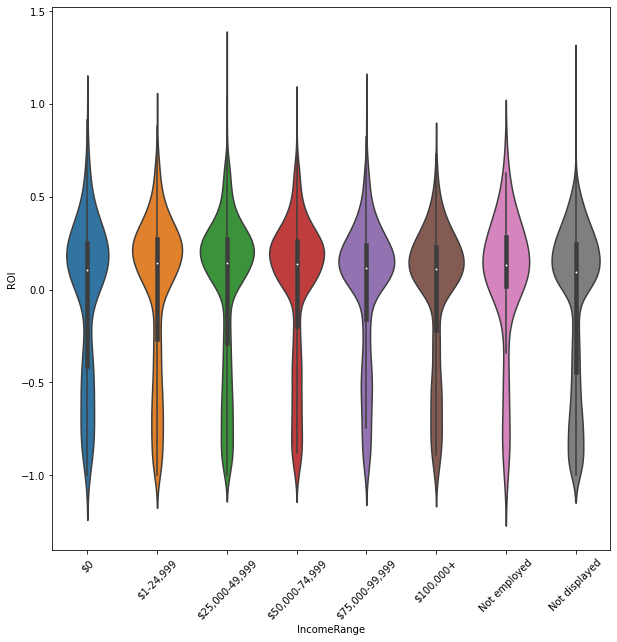

In [137]:
plt.figure(figsize = [10,10])
sb.violinplot(data=loans_to_2008, x='IncomeRange', y='ROI')
plt.xticks(rotation=45);

There doesn't seem to be much difference in ROI at different income ranges. The plots do get a little wider at the higher ranges -- suggesting that more loans are closer to the median (a symptom of less risk loans: more loans turn out the way you predicted they would, which I guess is around a 10% return (since all the means are around 10% and I imagine that has to do with charging higher interest rates to riskier loans)). 

Why don't the Credit Rating and Income Range violin plots look more alike? I guess because with more data than just a borrower's income range, Prosper makes better guesses about the loan outcomes and is better at predicting who they should lend to and how much they should charge them -- this makes the statistically richer plots (like box and violin plots) correspond better to Credit Grade than Income Range, even in rough times.

Before proceeding, I'd like to see how my two possible primary metric -- ROI and Succesful/Unsuccessful relate to each other.

#### NewLoanStatus vs ROI

In [138]:
ns_roi = (loans_to_2008.groupby('NewLoanStatus').ROI.mean()).copy()
ns_roi

NewLoanStatus
Cancelled      -1.000000
Successful      0.226617
Unsuccessful   -0.454085
Name: ROI, dtype: float64

<AxesSubplot:xlabel='NewLoanStatus'>

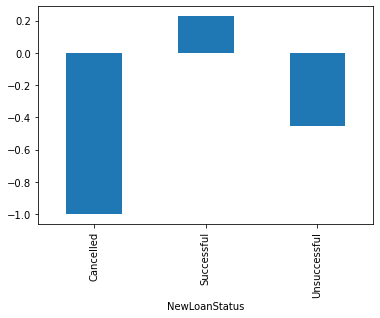

In [139]:
ns_roi.plot.bar()

<AxesSubplot:xlabel='NewLoanStatus'>

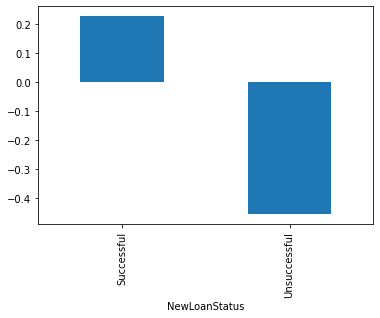

In [140]:
# there's only 5 cancelled loans in the data set, so let's just get rid of them
nocan = (loans_to_2008[loans_to_2008['NewLoanStatus'] != 'Cancelled']).copy()
nocan = nocan.groupby('NewLoanStatus').ROI.mean()
nocan.plot.bar()

This seems to be a fairly significant correlation. On average, the Successful loans have a 20% return and the Unsuccessful ones have a -40% return. Maybe my original primary metric was OK, after all. But ROI still seems better, as it gives more details about the loan outcomes.

### CreditGrade vs NewLoanStatus & IncomeRange vs NewLoanStatus

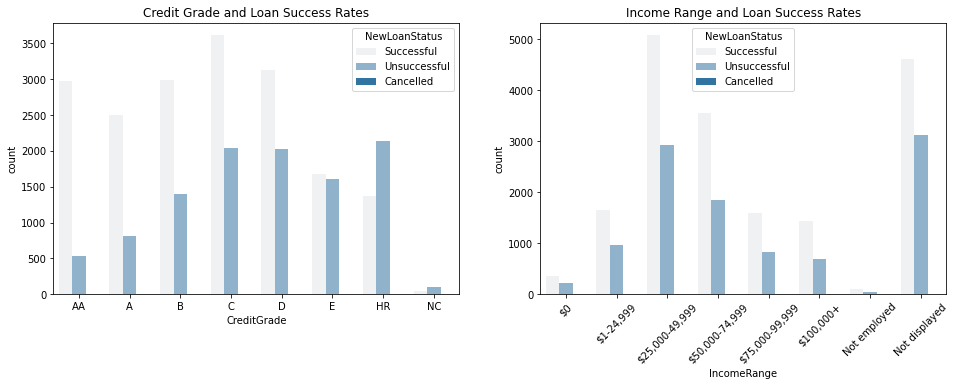

In [141]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

# LEFT plot: credit grade vs NewLoanStatus (Successful/Unsuccessful)
plt.subplot(1, 2, 1)
sb.countplot(data=loans_to_2008, x='CreditGrade', hue='NewLoanStatus', color=base_color);
plt.title('Credit Grade and Loan Success Rates')


# RIGHT plot: box plot
plt.subplot(1, 2, 2)
sb.countplot(data=loans_to_2008, x='IncomeRange', hue='NewLoanStatus', color=base_color)
plt.title('Income Range and Loan Success Rates')
plt.xticks(rotation=45);

For Credit Grade, the Unsuccessful loans increase pretty linearly from AA to A to B to C. The AA Successful loans are quite a bit higher than the A; but the Successful loans progress pretty linearly from A to B to C. 

Similar trends can be found in the medium three income ranges. 

I think this data would be more useful if the Successful and Unsuccesful loans were measured as percentages of the total loans for each Credit Grade or Income Range. 

##### Making the NewLoanStatus variable numeric and using it to compare the percent of successful or unsuccessful loans at different Credit Grades

In [142]:
# make a new data frame that makes the NewLoanStatus column numeric

numeric_status = loans_to_2008.copy()
dict_map = dict(zip(['Successful', 'Unsuccessful', 'Cancelled'], [1, 0, 0]))

numeric_status['NewLoanStatus'] = loans_to_2008['NewLoanStatus'].map(dict_map)
numeric_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29056 entries, 0 to 29055
Data columns (total 85 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           29056 non-null  object        
 1   ListingNumber                        29056 non-null  int64         
 2   ListingCreationDate                  29056 non-null  datetime64[ns]
 3   CreditGrade                          28940 non-null  category      
 4   Term                                 29056 non-null  int64         
 5   LoanStatus                           29056 non-null  object        
 6   ClosedDate                           29056 non-null  object        
 7   BorrowerAPR                          29031 non-null  float64       
 8   BorrowerRate                         29056 non-null  float64       
 9   LenderYield                          29056 non-null  float64       
 10  EstimatedE

In [143]:
# group the credit grades together and find the average values for all columns

cg_percentages = numeric_status.groupby('CreditGrade').mean()
cg_percentages.head()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
CreditGrade,,,,,,,,,,,,,,,,,,,,,
AA,221389.092645,36.0,0.106188,0.098066,0.092331,NaN,NaN,NaN,NaN,NaN,...,1433.558766,1387.638756,39.524615,1.000000,0.192987,0.113740,55.064795,188.133124,0.846066,0.018847
A,222908.348023,36.0,0.135710,0.125107,0.116858,NaN,NaN,NaN,NaN,NaN,...,2046.325548,1983.434805,74.910024,1.000003,0.136432,0.071235,47.106414,186.782372,0.755810,-0.000372
B,225470.874373,36.0,0.164317,0.153568,0.143226,NaN,NaN,NaN,NaN,NaN,...,2224.422843,2150.458753,102.168263,1.000000,0.140903,0.067715,47.864291,168.337209,0.680347,-0.006543
C,216176.860028,36.0,0.193434,0.179668,0.169059,NaN,NaN,NaN,NaN,NaN,...,1794.225698,1736.129667,91.301770,1.000000,0.126683,0.051914,43.761217,112.031184,0.638909,-0.004018
D,202643.606290,36.0,0.225463,0.211864,0.201086,NaN,NaN,NaN,NaN,NaN,...,1456.824021,1418.683487,74.046653,1.000000,0.135702,0.064648,60.368074,84.676374,0.606484,0.010531


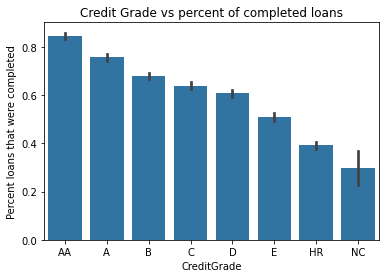

In [144]:
# create a graph of credit grade verus percent successful

sb.barplot(data=numeric_status, x='CreditGrade', y='NewLoanStatus', color=base_color)
plt.title('Credit Grade vs percent of completed loans')
plt.ylabel('Percent loans that were completed');

That shows a fairly clear correlation.

I'll try the same with Income Ranges

In [145]:
# group by income range together and find the average values for all columns

ir_percentages = numeric_status.groupby('IncomeRange').mean()
ir_percentages.head(8)

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,NewLoanStatus,ROI
IncomeRange,,,,,,,,,,,,,,,,,,,,,
$0,281325.385417,36.000000,0.203395,0.189685,0.180276,NaN,NaN,NaN,NaN,NaN,...,2678.350920,2633.086302,78.380000,1.000000,0.428819,0.312500,321.902083,115.057292,0.611111,-0.044269
"$1-24,999",252019.864731,36.000000,0.205540,0.190458,0.179201,NaN,NaN,NaN,NaN,NaN,...,1166.728280,1121.210222,55.140951,1.000000,0.207107,0.096676,78.219606,82.332442,0.633550,-0.003285
"$25,000-49,999",255652.079920,35.997003,0.202081,0.187482,0.176408,NaN,NaN,NaN,NaN,NaN,...,1404.701505,1357.476025,68.040249,1.000000,0.187063,0.087787,63.214170,112.253996,0.633741,-0.007522
"$50,000-74,999",258727.784738,36.000000,0.193267,0.179642,0.169176,NaN,NaN,NaN,NaN,NaN,...,1722.581789,1663.684551,106.791160,1.000000,0.164634,0.081301,59.250078,143.195492,0.657243,0.006745
"$75,000-99,999",258692.036409,36.000000,0.180352,0.167715,0.157874,NaN,NaN,NaN,NaN,NaN,...,2159.522664,2068.324688,122.833438,1.000000,0.155565,0.079851,51.334175,173.000827,0.658254,0.000262
"$100,000+",258068.226504,36.000000,0.173791,0.162130,0.152766,NaN,NaN,NaN,NaN,NaN,...,2946.712805,2870.745352,116.374544,1.000000,0.166353,0.083647,76.277279,216.613722,0.671523,-0.021490
Not employed,250140.433121,36.000000,0.201366,0.186150,0.175258,NaN,NaN,NaN,NaN,NaN,...,775.556752,759.275605,36.611529,1.000000,0.273885,0.191083,59.415159,59.585987,0.719745,0.051622
Not displayed,49011.464023,36.000000,0.198602,0.189181,0.179915,NaN,NaN,NaN,NaN,NaN,...,1435.865942,1405.989057,45.634112,1.000001,0.003488,0.001679,0.883239,68.418938,0.595530,-0.075842


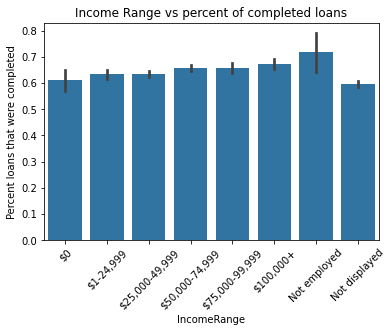

In [146]:
# create a graph of credit grade verus percent successful

sb.barplot(data=numeric_status, x='IncomeRange', y='NewLoanStatus', color=base_color)
plt.title('Income Range vs percent of completed loans')
plt.ylabel('Percent loans that were completed')
plt.xticks(rotation=45);

60% success rate for \\$0 income. Something like 62% for the newt two ranges. And then up to maybe 65% for both the \\$50K-\\$74K and the \\$75K-\\$99K ranges. And then up another percentage point or so for the highest income range. That's a trend, although not as strong as I would've predicted. And why would the unemployed be the best at paying off their loans??

This also does not agree with the previous map of Gredit Grade vs ROI. 

### StatedMonthlyIncome vs ROI

Text(0.5, 1.0, 'Stated Monthly Income VS ROI')

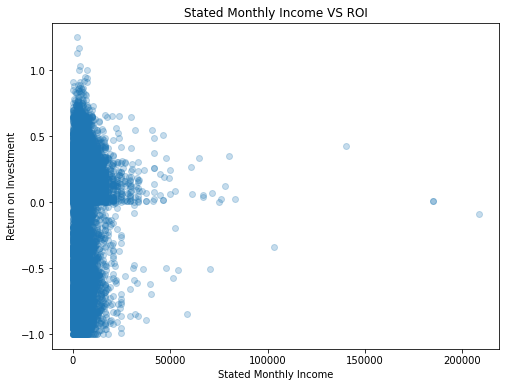

In [147]:
plt.figure(figsize = [8, 6])
#xticks = [100,500,1000,,2, 3, 4, 6, 8,10]
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
#plt.xticks(xticks, xticks)

There's some crazy outliers.
First I'll see what happens if we zoom in to the bulk of the data.

(0.0, 50000.0)

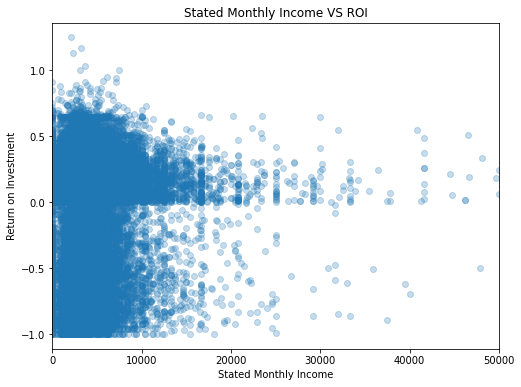

In [148]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 50000)

Past 25,000 there are proportionately very few values.

Let's see what happens if we zoom in further.

(0.0, 25000.0)

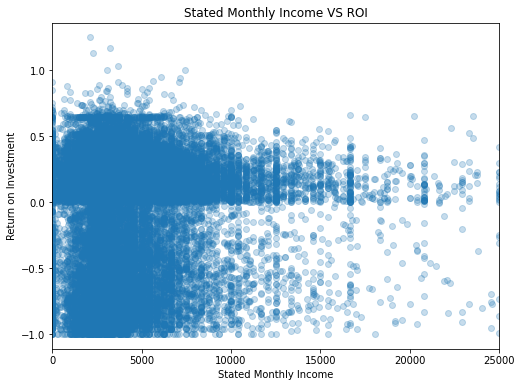

In [149]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 25000) 

(0.0, 20000.0)

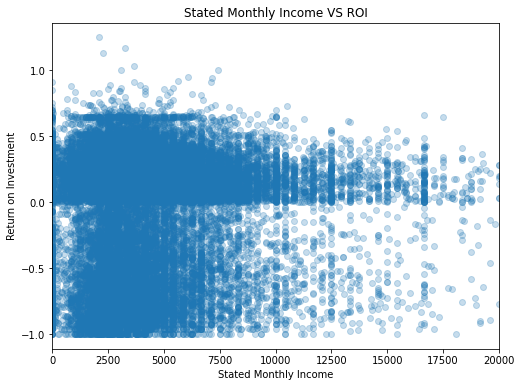

In [150]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 20000) 

(0.0, 15000.0)

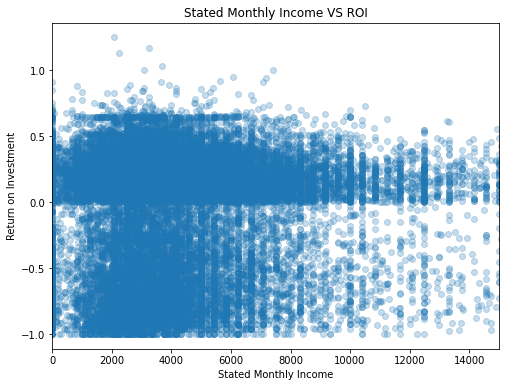

In [151]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 15000) 

(0.0, 10000.0)

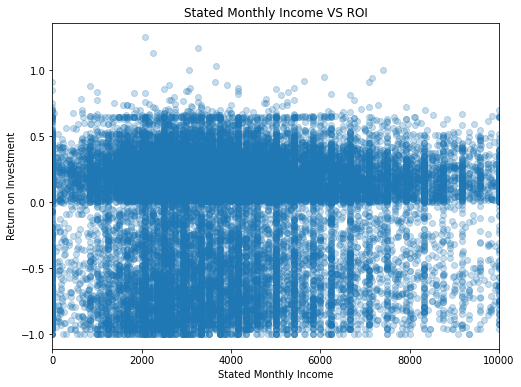

In [152]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(0, 10000) 

(0.0, 6000.0)

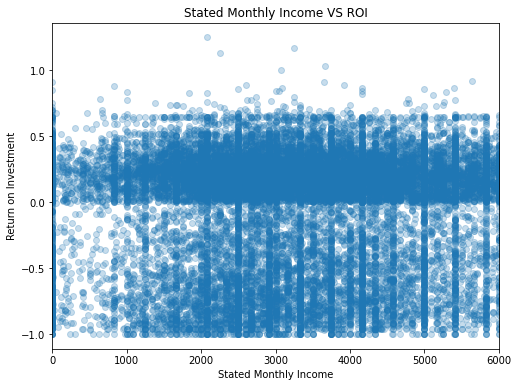

In [153]:
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', alpha=1/4)
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.xlim(-0, 6000) 

Zooming in seems to make the trend I initially noticed -- a little downward slope in ROIs as incomes go up -- disappear. Let's try a log tansformation.

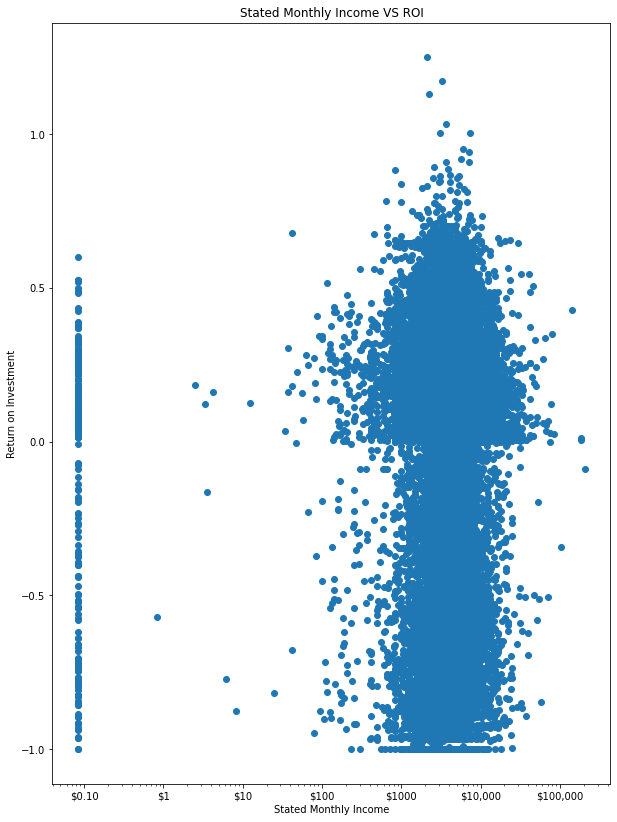

In [154]:
plt.figure(figsize=[10, 14])
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y='ROI')
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI')
plt.show()

There seems to be a trend -- the ROIs increase as we go up from a couple hundred to thousands of dollars a month; and then start sloping down again a little before \\$10K a month.

Let's see what Pearson says.

In [155]:
monthly_roi = (loans_to_2008[['StatedMonthlyIncome', 'ROI']]).copy()
monthly_roi.head()

,StatedMonthlyIncome,ROI
0,3083.333333,0.223270
1,2083.333333,0.403142
2,1666.666667,0.012530
3,5833.333333,-0.435110
4,3750.000000,0.370723


In [156]:
monthly_roi.corr(method='pearson')

,StatedMonthlyIncome,ROI
StatedMonthlyIncome,1.000000,0.021878
ROI,0.021878,1.000000


In [157]:
monthly_roi.corr(method='spearman')

,StatedMonthlyIncome,ROI
StatedMonthlyIncome,1.000000,0.002896
ROI,0.002896,1.000000


According to Pearson, Stated Montly Income is not a good predictor of ROI.

What would happen if we do a Pearson evaluation on the section with most of the data -- from say \\$300 to \\$30,000 a month?

In [158]:
typical_incomes_1 = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 30000) & (loans_to_2008['StatedMonthlyIncome'] >= 300)]).copy()
typinc_roi_1 = (typical_incomes_1[['StatedMonthlyIncome', 'ROI']]).copy()
typinc_roi_1.head()

,StatedMonthlyIncome,ROI
0,3083.333333,0.223270
1,2083.333333,0.403142
2,1666.666667,0.012530
3,5833.333333,-0.435110
4,3750.000000,0.370723


In [159]:
typinc_roi.corr(method='pearson')

NameError: name 'typinc_roi' is not defined

In [ ]:
typinc_roi.corr(method='spearman')

Still not a significant correlation. What if I honed into more typical incomes, say \\$1K to \\$10K per month?

In [ ]:
typical_incomes_2 = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 10000) & (loans_to_2008['StatedMonthlyIncome'] >= 1000)]).copy()
typinc_roi_2 = (typical_incomes_2[['StatedMonthlyIncome', 'ROI']]).copy()

typinc_roi_2.corr()

In [ ]:
typinc_roi_2.corr(method='spearman')

I am disappointed that so far of the possible predictor variables I studied, only Credit Grade is looking like a very good predictor. So I will add in the CreditScoreRangeUpper, which I believe must be correlated with outcomes. (CreditScoreRangeLower should be too. I have no particular reason for choosing Upper over Lower. When I run .corr() tests on a predictor value versus first one and then the other, I get identical scores; so I assume they are for our purposes here essentially interchangeable.)

In [ ]:
# try a scatter plot
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, x = 'CreditScoreRangeUpper', y = 'ROI', alpha=1/4)
plt.xlabel('Credit Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')
#plt.xlim(0,1000)

In [ ]:
# now a bar with groupby

loans_to_2008[['CreditScoreRangeUpper', 'ROI']].groupby('CreditScoreRangeUpper').ROI.mean().plot.bar(edgecolor='black', figsize=[14,8], width=.9);
plt.xlabel('Credit Score Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')

The middle Credit Ranges show mixed results; the lower scores are uniformly negative average ROIs. Only up around upper credit ranges of about 800 does Prosper start to turn a solid profit. Below the 579 credit rating even their average ROI is consistently a loss of 10% or more.

This doesn't seem to fit with our investigations of Credit Grade and ROI -- even the lowest Credit Grades had positive ROIs.

Let's run the correlation tests.

In [ ]:
csru_roi = (loans_to_2008[['CreditScoreRangeUpper', 'ROI']]).copy()
csru_roi.corr()

In [ ]:
csru_roi.corr(method='spearman')

What happens if we remove those few low scores?

In [ ]:
typical_csru = (loans_to_2008[loans_to_2008['CreditScoreRangeUpper'] >= 400]).copy()
typcsru_roi = (typical_csru[['CreditScoreRangeUpper', 'ROI']]).copy()

typcsru_roi.corr()

In [ ]:
typcsru_roi.corr(method='spearman')

Let's go over Credit Score Range versus Credit Grade and versus StatedMonthlyIncome

#### Credit Grade vs Credit Score Range (Upper & Lower)

In [ ]:
plt.figure(figsize = [20, 16])

# subplot 1: Credit Grade  vs CSRU
plt.subplot(2, 1, 1)
a = sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeUpper', hue = 'CreditGrade', palette = 'hls')
#ax.legend(ncol = 2) # re-arrange legend to reduce overlapping
plt.xticks(rotation=45)


# subplot 2: Credit Grade  vs CSRL
ax = plt.subplot(2, 1, 2)
b = sb.countplot(data = loans_to_2008, x = 'CreditScoreRangeLower', hue = 'CreditGrade', palette = 'hls')
#ax.legend(ncol = 2) # re-arrange legend to reduce overlapping
plt.xticks(rotation=45)


plt.show()

The lowest credit score range is NC, then there's several HR. 540 is the only range with two credit grades (HR and E). In general, the lower Credit Grades are in the lower score ranges. As you'd think.

This also explains the apparent discrepancy between our ROI versus CG and our our ROI versus CSRU findings -- the reason that CreditGrade has uniformly positive ROIs is that the lowest score E correlates to a CSRU of at least 540. The really low CSRU scores (with the uniformly negative ROIs) don't even get letter rating. 

#### Credit Score Range versus Stated Monthly Income

In [ ]:
# scatter plot
plt.figure(figsize = [8, 6])
plt.scatter(data = loans_to_2008, y = 'CreditScoreRangeUpper', x = 'StatedMonthlyIncome', alpha=1/4)
            
plt.ylabel('Credit Range (Upper)')
plt.xlabel('Stated Monthly Income')
plt.title('Credit Range VS SMI')
#plt.xlim(0,1000)

There looks like a slight but meaningful relationship. As income goes up, Credit Range goes up too.

### Spearman correlations with categorical variables

#### See the bottom of this section for a chart with spearman and pearson scores greater than |.1|

Let's run computational correlation tests on some categorical variables versus ROI (numeric) and Successful/Unsuccessful (categoric).

In [ ]:
# preparing the Credit Grade for .corr() by removing non-ordinal components

cg_corr = (loans_to_2008.query("CreditGrade not in ['NC', 'HR']")).copy()
cg_corr.groupby('CreditGrade').mean()

In [ ]:
# turn categories into numbers
# 1. create a list of unique categories & the corresponding numbers

credit_categories = ["AA", "A", "B", "C", "D", "E"]
numeric_categories = [1, 2, 3, 4, 5, 6]

#2. create a dictionary of the lists with zip

mapping_dict = dict(zip(credit_categories, numeric_categories))

#3. create a new variable

loans_to_2008['CreditGradeNumeric'] = loans_to_2008['CreditGrade'].map(mapping_dict)

#4. check

loans_to_2008['CreditGradeNumeric'].value_counts().sort_index()

In [ ]:
# 5. compare
loans_to_2008['CreditGrade'].value_counts().sort_index()

In [ ]:
# spearman correlation between ROI and CG

loans_to_2008.dropna(subset=['CreditGradeNumeric', 'ROI'])[['CreditGradeNumeric', 'ROI']].corr(method='spearman')

Spearman is interpreted like this:

.00-.19 “very weak”  /  .20-.39 “weak”  /  .40-.59 “moderate”  /  .60-.79 “strong”  .80-1.0 “very strong”

So this is a very weak correlation.

Let's just see what happens if we try a pearson.

In [ ]:
loans_to_2008.dropna(subset=['CreditGradeNumeric', 'ROI'])[['CreditGradeNumeric', 'ROI']].corr(method='pearson')

OK, well, that wasn't supposed to work anyway.

I'm not having much luck finding a good predictor.

Credit Grade should've been a very good predictor.

If I can't get a meaningful correlation here, I think I have to conclude there is something wrong with my ROI (return on investment) metric.

Let's just see if we can do any better with CreditScoreRange. It's sliced up more finely than Credit Grade, so if ROI is at least on the right track, CSR should do better than the .14 that CG gave us.

In [ ]:
csrl_roi = loans_to_2008[['CreditScoreRangeLower', 'ROI']].copy()
csrl_roi.corr()

In [ ]:
csrl_roi.corr(method='spearman')

I didn't think the spearman would work. But I thought the pearsons would've shown a clear correlation between my return on investment metric and CreditScoreRangeLower (which is a numeric value, and which should thus be able to line up linearly with roi, another numeric value).

Here again I was sorely disappointmed. 

.1 is the bottom cut-off for a low pearson's correlation.

So .12 is definitely low. So low as to be meaningless? Probably. A medium correlation starts at .3

I'll just look at the Upper to see if it's any different.

In [ ]:
loans_to_2008.CreditScoreRangeUpper.value_counts()

In [ ]:
csrup_nonan = (loans_to_2008.query("CreditScoreRangeUpper not in 'nan'")).copy()
csrup_nonan.groupby('CreditScoreRangeUpper').mean()

In [ ]:
csrup_roi = csrup_nonan[['CreditScoreRangeUpper', 'ROI']]

csrup_roi.corr()

In [ ]:
csrup_roi.corr(method='spearman')

I'm surprised that CreditScoreRangeUpper and CreditScoreRangeLower have identical spearman scores. But, anyway, the point is, neither is a good predictor variable for my return on investment (ROI) variable.

This makes me feel like my ROI is pretty useless. Surely the credit score ranges are a good predictor value for a loan's return. They are made by the lenders for the sole purpose of turning a profit and lenders don't generally go broke. The housing collapse wasn't until 2008. Most of the loans in this data set would've been up before then. So the aggregate of the loans should've turned out about as the credit scores predicted. Therefore, it seems that my ROI must be somehow wanting. 

I'll see if my original metric -- Successful/Unsuccessful based on whether or not the loan was completed -- does any better.

In [ ]:
nls_corr = (loans_to_2008.query("NewLoanStatus not in 'Cancelled'")).copy()
nls_corr.groupby('NewLoanStatus').mean()

In [ ]:
# turn categories into numbers
# 1. create a list of unique categories & the corresponding numbers

credit_c = ["Successful", "Unsuccessful"]
numeric_c = [1, 0]

#2. create a dictionary of the lists with zip

m_dict = dict(zip(credit_c, numeric_c))

#3. create a new variable

nls_corr['NLSNumeric'] = nls_corr['NewLoanStatus'].map(m_dict)

#4. check

nls_corr['NLSNumeric'].value_counts().sort_index()

In [ ]:
# isoloate loan status and roi

nls_roi = nls_corr[['NLSNumeric', 'ROI']]

nls_roi.corr(method='spearman')

OK, so at least my two metrics for measuring a loan's success correlate with each other.

Now let's find out if NewLoanStatus or ROI more closely correlates to the would-be predictors.

In [ ]:
# isolate loan status and stated monthly income

nls_smi = nls_corr[['NLSNumeric', 'StatedMonthlyIncome']]

nls_smi.corr()

In [ ]:
# isolate loan status and stated monthly income

nls_smi = nls_corr[['NLSNumeric', 'StatedMonthlyIncome']]

nls_smi.corr(method='spearman')

Try the same, but throw out the most extreme values.

In [ ]:

typ_inc_nls_1 = (nls_corr[(nls_corr['StatedMonthlyIncome'] <= 30000) & (nls_corr['StatedMonthlyIncome'] >= 800)]).copy()
typi_nls_smi_1 = (typ_inc_nls_1[['StatedMonthlyIncome', 'NLSNumeric']]).copy()

typi_nls_smi_1.corr()

In [ ]:
typi_nls_smi_1.corr(method='spearman')

Hmm, still no very meaningful correlation between Stated Monthly Income and the Successful/Unsuccessful metric.

Let's try honing in on a very typical income range.

In [ ]:
typ_inc_nls_2 = (nls_corr[(nls_corr['StatedMonthlyIncome'] <= 10000) & (nls_corr['StatedMonthlyIncome'] >= 1000)]).copy()
typi_nls_smi_2 = (nls_corr[['StatedMonthlyIncome', 'NLSNumeric']]).copy()

typi_nls_smi_2.corr()

In [ ]:
typi_nls_smi_2.corr(method='spearman')

OK, that didn't help.

#### Checking CG versus NLS

In [ ]:
# add Credit Grade to this data frame

# turn categories into numbers
# 1. create a list of unique categories & the corresponding numbers

credit = ["AA", "A", "B", "C", "D", "E"]
numeric = [1, 2, 3, 4, 5, 6]

#2. create a dictionary of the lists with zip

last_dict = dict(zip(credit, numeric))

#3. create a new variable

nls_corr['CreditGradeNumeric'] = nls_corr['CreditGrade'].map(last_dict)

#4. check

nls_corr['CreditGradeNumeric'].value_counts().sort_index()

In [ ]:
# isolate Credit Grade and NLS

nls_cg = nls_corr[['NLSNumeric', 'CreditGradeNumeric']]

nls_cg.corr(method='spearman')

.2 is the very beginning of the 'weak' correlation range. 

But the graphs earlier had shown that as the credit grades went down, the percent of completed loans also went down. Oh! Maybe I should've given the highest credit grades the highest numbers. That makes sense. If that's the case, and for AA to get the highest rank it needs the highest number, then I numbered the categories backwards, and I can conclude that this spearman result roughly matched my graph above: a very slight positive correlation.

Finally, let's see how CreditScoreRangeUpper compares to NLSNumeric.

In [ ]:
# isolate CSRU and NLS

nls_csru = nls_corr[['NLSNumeric', 'CreditScoreRangeUpper']]

nls_csru.corr(method='spearman')

Huh. What can we say but the fancy ROI metric didn't do nearly as well the simple Completed/Not-Completed metric. Clearly, the ROI metric is missing something. There must be some important part of the return on investment calculation that did not make it into my ROI calcultion. Either that, or I don't know what. Since return on investment really should correlate to credit score range and the other predictor variables.

Did I ever compare CreditScoreRangeUpper with Stated Monthly Income?

In [ ]:
# isolate csru and smi

nls_smi = nls_corr[['CreditScoreRangeUpper', 'StatedMonthlyIncome']]

nls_smi.corr(method='spearman')

In [ ]:
# isolate csru and smi

nls_smi = nls_corr[['CreditScoreRangeUpper', 'StatedMonthlyIncome']]

nls_smi.corr()

That doesn't make sense. CSRU correlates weakly but still meaningfully to both Stated Monthly Income and NewLoanStatus (.24 and .27 spearman scores, respectively); but Stated Monthly Income and NewLoanStatus have no meaningful correlation (.05 spearman score). How can that be? 

Credit Score Range and Credit Grade should be closely correlated. Let's run a spearman on them. If that doesn't come out well, we know there is something wrong with the way we're doing computational correlations.

In [ ]:
# isolate csru and cg

csru_cg = nls_corr[['CreditScoreRangeUpper', 'CreditGradeNumeric']]

csru_cg.corr(method='spearman')

OK, that's reassuring. As noted above, with the way we created CreditGradeNumeric, a negative spearman score represents a positive correlation (because we gave the highest grades the lowest numbers). .98 is a very high correlation, and that is what we'd expect from these two variables (CG is basically just a less-detailed version of the credit score ranges).

For completeness, I'll run spearman tests on NewLoanStatus versus both DebtToIncomeRatio and AmountDelinquent.

In [ ]:
# isolate nls and dti

nls_dti = nls_corr[['NLSNumeric', 'DebtToIncomeRatio']]

nls_dti.corr(method='spearman')

In [ ]:
# isolate nls and ad

nls_ad = nls_corr[['NLSNumeric', 'AmountDelinquent']]

nls_ad.corr(method='spearman')

Debt to Income wasn't even a |.1| correlation, but Amount Delinquent was |.15| -- a very weak corelation (but still a correlation).

### Overview of .corr() results for outcomes greater than |.1|

| Variables | Result | Type of Test |
| :- | -: | :-: |
| ROI / Credit Grade | .138815 | spearman
| ROI / Credit Score Range | .121623 | pearson
| NLS / Credit Grade | .201647 | spearman
| NLS / Credit Score Range | .265645 | spearman
| NLS / Amount Delinquent | - .150028 | spearman
| ROI / NLS | .722029 | spearman
| Stated Monthly Income / Credit Score Range | .240603 | spearman
| Stated Monthly Income / Credit Score Range | .198644 | pearson
| Credit Grade / Credit Score Range | .98771 | spearman

NLS = NewLoanStatus = Successful/Unsuccessful based on whether or not the loan was completed.

ROI = Return on Investment (see calculation in the Prepare Data for Analysis section at the top of this notebook).

Whenever Credit Grade was one of the variables, the results here have been multiplied by -1 (because I created the CreditGradeNumeric variable backwards)

Spearman is interpreted like this:

.00-.19 “very weak" / .20-.39 “weak” / .40-.59 “moderate” / .60-.79 “strong” .80-1.0 “very strong”

Pearson is interpreted like this:

.1 - .3 "small" / .3 to .5 "medium" / .5 to 1 "large"

(Maybe both should be interpreted like this?)

#### Discussion of .corr() score results can be found in the intro to the multivariate plots section

#### ROI versus Borrower State, Occupation, Home Owner Status and Employment Status

There's two more categories to compare against ROI:

nominal_vars = ('BorrowerState', 'Occupation')

binary_vars = ('IsBorrowerHomeowner', 'EmploymentStatus')

##### I didn't spend too much time on these or notice any very interesting trends. Feel free to skip down to the multivariate section.

In [ ]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 36])
g = sb.boxplot(data = loans_to_2008, x = 'ROI', y = 'BorrowerState', color=default_color)

plt.xticks(rotation=45)
plt.show();

In [ ]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 36])
g = sb.barplot(data = loans_to_2008, x = 'ROI', y = 'BorrowerState', color=default_color)

plt.xticks(rotation=45)
plt.show();

In [ ]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 20])
g = sb.boxplot(data = loans_to_2008, x = 'ROI', y = 'Occupation', color=default_color)

plt.xticks(rotation=45)
plt.show();

In [ ]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 20])
g = sb.barplot(data = loans_to_2008, x = 'ROI', y = 'Occupation', color=default_color)

plt.xticks(rotation=45)
plt.show()

In [ ]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [8, 8])
g = sb.boxplot(data = loans_to_2008, x = 'ROI', y = 'EmploymentStatus', color=default_color)

plt.xticks(rotation=45)
plt.show();

In [ ]:
default_color = sb.color_palette()[0]
plt.figure(figsize = [20, 20])
g = sb.boxplot(data = loans_to_2008, x = 'IsBorrowerHomeowner', y = 'ROI', color=default_color)

plt.xticks(rotation=45)
plt.show();

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The ROI primary variable results were disappointing and confusing. 

When graphed, the StatedMonthlyIncome looked like it correlated fairly well to ROI, but the pearson score was very low (.02 for all the data; .03 when we zoomed in on the bulk of the data). 

Of the many variables describing the borrows that I examined, only CreditScore and CreditScoreRange seem to be good indicators of a loan's ROI score.

But why did I get such a trivial ROI/SMI score when the graph of ROI/SMI seemed to show a small but meaningful relationship, and when ROI/NLS, NLS/SMI, ROI/CSRU, and CSRU/SMI all had meaningful-looking .corr() correlation results?

The NewLoanStatus primary variable results were less disappointing, but the metric itself seems less meaningful because it doesn't account for as many variables as ROI. For example: NewLoanStatus only tells us whether or not a loan was completed, but sometimes an uncompleted loan still makes money,and the amount of money an uncompleted loan loses varies widely; that's why I calculated the return on investment variable in the first place.

NewLoanStatus had higher correlations with the credit-based variables (CreditGrade, CreditScoreRangeUpper and CreditScoreRangeLower) than ROI did. It also had a (very small but still meaningful) correlation with SMI and (an even smaller one) with AmountDelinquent. ROI correlation scores for both SMI and AD were well below .1

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Stated Monthly Income and Income Ranges were closely related -- as you'd think they should be. There was also a discernible relationship between Credit Score and Income Ranges, and between CreditScoreRange and CreditGrade. All as you'd expect.

## Multivariate Exploration

> To help choose the which multivariate plots to investigate, let's review our .corr() results.


| Variables | Result | Type of Test |
| :- | -: | :-: |
| ROI / Credit Grade | .138815 | spearman
| ROI / Credit Score Range | .121623 | pearson
| ROI / Credit Score Range | -.043215 | spearman
| NLS / Credit Grade | .201647 | spearman
| NLS / Credit Score Range | .265645 | spearman
| NLS / Amount Delinquent | - .150028 | spearman
| ROI / NLS | .722029 | spearman
| Stated Monthly Income / Credit Score Range | .240603 | spearman
| Stated Monthly Income / Credit Score Range | .198644 | pearson
| Credit Grade / Credit Score Range | .98771 | spearman

NLS = NewLoanStatus = Successful/Unsuccessful based on whether or not the loan was completed.

ROI = Return on Investment (see calculation in the Prepare Data for Analysis section at the top of this notebook).

Whenever Credit Grade was one of the variables, the results here have been multiplied by -1 (because I created the CreditGradeNumeric variable backwards)

Spearman is interpreted like this:

.00-.19 “very weak" / .20-.39 “weak” / .40-.59 “moderate” / .60-.79 “strong” .80-1.0 “very strong”

Pearson is interpreted like this:

.1 - .3 "small" / .3 to .5 "medium" / .5 to 1 "large"

The highest non-trivial correlations found with the Pearson and Spearman tests were ROI/NLS (spearman .723); NLS/Credit Score Range (spearman .266); Stated Monthly Income / Credit Score Range (spearman .241; pearson .198644); and NLS/Credit Grade (spearman .201647). 

We could perhaps also add ROI/Credit Score Range (pearson .121623 -- that's a small correlation, but it is the best correlation that I found with ROI and any of the predictor variables.

I'll focus my multivariate explorations on these variables. 

I don't understand why comparing ROI with the various predictor variables resulted in pearson scores so much lower than the spearman scores I got when comparing NLS to those same predictor variables. 

Should pearson be weighted higher? Note that SMI/CSR got a Pearson score of .1986 and a Spearman score of .2406 That makes one think that the two methods are interchangeable when both variables are numeric, and that the Pearson's score should be weighted higher than Spearman's. However, then we have the case of ROI/CSR -- two numeric variables, graphs show a correlation, Pearson has a small but perhaps meaningful score of .12, but then Spearman comes in with a -.04! What are we to make of that? That's 1/3 the size of the Spearman (in the SMI/CSR example, the Spearman was .83 times as big as the Pearson).

It would be nice if the multivariate plots could give me some insight into why NLS got higher .corr() scores than ROI. 

Of particular interest: Why did I get such a trivial ROI/SMI score when the graph of ROI/SMI seemed to show a small but meaningful relationship, and when ROI/NLS, NLS/SMI, ROI/CSRU, and CSRU/SMI all had meaningful-looking .corr() correlation results?

I don't really know how to approach these questions. I will try plots that combine the variables with the highest .corr() scores (ROI/NLS/SMI/CSR) and see what I get.

In [ ]:
g = sb.FacetGrid(data = loans_to_2008, hue = 'NewLoanStatus', size = 5, aspect=1.5)
g.map(plt.scatter, 'ROI', 'StatedMonthlyIncome')
g.add_legend()

In [ ]:
g = sb.FacetGrid(data = loans_to_2008, hue = 'NewLoanStatus', size = 5, aspect= 1.5, hue_order = ['Unsuccessful', 'Successful'])
g.map(plt.scatter, 'ROI', 'StatedMonthlyIncome')
g.add_legend()

Here we see what appear to be clear trends. The Unsuccessful loans are much more likely to lose money. They have almost uniformly positive ROIs. Strangely, as the Stated Monthly Income increases, the ROI decreases, and there are less total successful loans. 

How can I show what is going on behind the the orange part of the graph? I guess I could take a sample to reduce the number of plots.

In [ ]:
loans_to_2008.head()

In [ ]:
samples = np.random.choice(loans_to_2008.shape[0], 1000, replace = False)
loans_2008_samp = loans_to_2008.loc[samples,:]

g = sb.FacetGrid(data = loans_2008_samp, hue = 'NewLoanStatus', size = 5, aspect=1.5)
g.map(plt.scatter, 'ROI', 'StatedMonthlyIncome')
g.add_legend()

#### We also have to do a log transformation on StatedMonthlyIncome.

We learned in the bivariate section that without a log transformation, StatedMonthlyIncome results in a halved graph.


In [ ]:
plt.figure(figsize=[10, 14])
g = sb.FacetGrid(data = loans_2008_samp, hue = 'NewLoanStatus', size = 5, aspect=1.5)
g.map(plt.scatter, 'ROI', 'StatedMonthlyIncome')
g.add_legend()
plt.yscale('log')
plt.yticks([.10, 1, 10, 100, 1000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$10,000', '$100,000'])
plt.ylabel('Stated Monthly Income')
plt.xlabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI vs NewLoanStatus')
plt.show()

#### There's a lot of empty space. Let's zoom in on the more typical income levels.

In [ ]:
typical_incomes = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 30000) & (loans_to_2008['StatedMonthlyIncome'] >= 800)]).copy()

typical_incomes.reset_index(drop=True, inplace=True)

In [ ]:
#typical_incomes.groupby('StatedMonthlyIncome').describe()

In [ ]:
samples = np.random.choice(typical_incomes.shape[0], 2500, replace = False)
typical_samp = typical_incomes.loc[samples,:]

g = sb.FacetGrid(data = typical_samp, hue = 'NewLoanStatus', size = 5, aspect=1.5, hue_order = ['Successful', 'Unsuccessful'])
g.map(plt.scatter, 'ROI', 'StatedMonthlyIncome')
g.add_legend()
plt.yscale('log')
plt.yticks([.10, 1, 10, 100, 1000, 2000, 3000, 6000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$2000','$3000','$6000','$10,000', '$100,000'])
plt.ylabel('Stated Monthly Income')
plt.xlabel('Return on Investment')
plt.title('Stated Monthly Income VS ROI vs NewLoanStatus')
plt.ylim(100, 100000)
plt.show()

Very few of the Unsuccessful loans have positive ROIs. But a few do. These loans must've been paid off for a long time before the borrower finally quit.

The Successful loans also seem to have a wider monthly income range than the Unsuccessful loans. 

When the ROI is between 0 and about .15, the incomes of the borrowers of the completed/Successful loans range from over \\$10K down to less than \\$1K. That income range becomes narrower as the ROIs increase. The most succesful ROIs (from about .6 through about .7) seem to go to people making from about \\$2K to \\$6K per month. 

From -1 to 0, the Unsuccessful loans's borrowers tend to have incomes from about \\$1K to \\$10K. As the ROIs get larger than 0, the Unsuccessful income range seems to narrow a bit, but there is no clear pattern.
 
By showing a definite trend in incomes as ROI increases, this graph (like the earlier bivariate ROI/SMI graph) seems to contradict the extremely low pearson score of ROI/SMI. But notice that the Unsuccessful loans have much more uniform incomes across the ROIs. Maybe the existence of a large uniform negative SMI/ROI relationship is obscuring the meaningful relationship between ROI and SMI for those loans that are successful?

In [ ]:
# select only the successful loans
successfuls = loans_to_2008[loans_to_2008['NewLoanStatus']=='Successful'].copy()

# isolate ROI and SMI

success_roi_smi = successfuls[['ROI', 'StatedMonthlyIncome']]

success_roi_smi.corr()

Yes!, the Successful loans do indeed have a meaningful correlation. As incomes go down, ROI goes up a little. The correlation is very small, but it is still there.

That finding is in accordance with both the bivariate and trivariate graph results, where it looked like Successful loans had a slight negative relationship to SMI: as income goes up, the loans make a little less money. 

We'd previously speculated that that trend is caused by the loan agencies setting rates to ensure they make a profit (thus charging people with lower credit ratings (and people with less money tend to have lower credit ratings) higher rates).

The data shows that they are beating their margin of error with the lower income people: they don't just make the same profit with lower income people as higher income people, they make a higher average profit with the lower income people.

But why should the Unsuccessful loans have pretty much uniform relationships between SMI and ROI? It seems clear that this large rectangle of the loans with negative ROIs is wrecking the correlation (there is no discernable correlation if all the x values correspond to the same set of y values), but why should the Unsuccessful loans create a ROI/SMI rectangle in the first place? Ie: Why should the Unsuccessful loans lack a meaningful relationship between monthly incomes and returns on investment?

This I am not Sure. Maybe it speaks to what happens when the lenders bet wrong: they no longer know what is going on and everything turns to a gray fog. 

#### ROI as a function of CSRU, with color-coded StatedMonthlyIncome

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(data = loans_to_2008, x = 'CreditScoreRangeUpper', y = 'ROI', c = 'StatedMonthlyIncome',
            cmap = 'mako_r')
plt.colorbar()
plt.xlabel('CreditScoreRangeUpper')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of CSRU, color-coded with SMI')
plt.show()

The existence of extreme salary outliers means that all the standard salaries are scrunched down at the bottom in the light greens. Let's see what happens when we remove the outliers.

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(data = typical_incomes, x = 'CreditScoreRangeUpper', y = 'ROI', c = 'StatedMonthlyIncome',
            cmap = 'mako_r')
plt.colorbar()
plt.xlabel('Credit Score Range (Upper)')
plt.ylabel('Return on Investment')
plt.title('CSRU vs ROI and SMI for typical incomes')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(data = typical_incomes, x = 'CreditScoreRangeUpper', y = 'ROI', c = 'StatedMonthlyIncome',
            cmap = 'mako_r')
plt.colorbar()
plt.xlabel('Credit Score Range (Upper)')
plt.ylabel('Return on Investment')
plt.title('CSRU vs ROI and SMI for typical incomes')
plt.xlim(300, 1000)
plt.show()

Positive ROI slopes up from CSRUs of about 450 to an apex around CSRU 600 and then down again until CSRU 900. Negative ROIs are pretty much a solid block from about CSRU 450 to CSRU 850. 

The graph gets a little darker (meaning incomes are going up) as you move towards higher credit ratings. 

There are dark plots on both positive and negative sides of the ROI, so it is hard to see much effect of income on ROI.

#### ROI as a function of SMI, with color-coded CSRU

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU')
#plt.xlim(100, 100000)
plt.show()


Zoom in:

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(data = loans_to_2008, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 4000, 6000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$4000','$6000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU')
plt.xlim(100, 100000)

plt.show()

Is this graph easier or harder to read than the first one? 

Note that the values with negative ROIs have fairly uniform SMIs, and that the SMIs of the positive ROIs correlate much more meaningfully to changes in ROI. This, again, is probably related to the fact that higher incomes tend to have slightly lower ROIs.

Note also that the most discernable darkening (indicating hightest credit ratings) is along the bottom of the positive section of ROI -- this we've seen in other graphs: the highest CSRUs correspond to lower ROIs.

#### ROI as a function of SMI, with CSRU color-coded -- as two graphs: Successful vs Unsuccessful

Let's combine the two above sets of multivariate explorations into two side-by side graphs that compare ROI, SMI and CSRU in two cases: Successful or Unsuccesful (ie: completed or uncompleted) loans.

In [ ]:
# break Successful and Unsuccesful databases

succ = loans_to_2008[loans_to_2008['NewLoanStatus']=='Successful'].copy()

unsucc = loans_to_2008[loans_to_2008['NewLoanStatus']=='Unsuccessful'].copy()

In [ ]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [20, 10])
base_color = sb.color_palette()[0]

# LEFT plot: SMI/CSRU/ROI - Successful loans
plt.subplot(1, 2, 1)
plt.scatter(data = succ, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 30000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$30,000','$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU');
plt.xlim(100, 100000)
plt.ylim(-1,1);
# RIGHT plot: box plot
plt.subplot(1, 2, 2)
plt.scatter(data = unsucc, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 30000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$30,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU - Uncompleted Loans')
plt.xlim(100, 100000)
plt.ylim(-1,1)
plt.show();


Both graphs increase the ROI as SMI goes up to about \\$6K, and then the ROIs slope down. But both the upward and downward slope is much more gradual on the Successful loans. Also, Unsuccessful loans represent pretty much all ROIs (even ones with very high ROIs!), but Successful loans have pretty much only positive ROIs.

Note that the darkest bands in the Successful graph are between ROIs of 0 and .1, and that both graphs tend to get darker as you move to the right. The first phenomenon we've previously attributed to Prosper giving people with better credit scores better rates (meaning Prosper makes less money on those Successful loans). The second phenomenon we should be able to attribute to an increase in credit scores as incomes go up. I'm only surprised that that latter trend is only perceived very slightly in these graphs. 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

#### ROI as a function of SMI, with color-coded Successful/Unsuccessful loan status: 

Very few of the Unsuccessful loans have positive ROIs. But a few do. These loans must've been paid off for a long time before the borrower finally quit.

The Successful loans also seem to have a wider monthly income range than the Unsuccessful loans.

By showing a definite trend in incomes as ROI increases, this graph (like the earlier bivariate ROI/SMI graph) seemed to contradict the extremely low pearson score of ROI/SMI. 

But with the multivariate graph, I noticed that the Unsuccessful loans have much more uniform incomes across the ROIs and speculated that perhaps the existence of a large uniform negative SMI/ROI relationship was obscuring the meaningful relationship between ROI and SMI. 

I removed the Unsuccessful loans from the data set, ran a Pearson test, and found a slight negative (about -.1) correlation between ROI and SMI in the Successful loans.

The phenomenon of lower ROIs correlating to higher SMIs in the Successful Loan subcategory, I attribute to Prosper giving better rates to people who make more money (generic example: a Successful Loan with a .1 interest rate is going to make less money than a Successful Loan with a .2 interest rate).

#### ROI as a function of CSRU, with color-coded StatedMonthlyIncome

Positive ROI slopes up from CSRUs of about 450 to an apex of around CSRU 600; the postive ROIs then slope down again until CSRU 900. Negative ROIs are pretty much a solid block from about CSRU 450 to CSRU 850. So we again see the phenomenon of better credit risk correlating with lower ROIs for Successful loans, but no discernable trend in the Unsuccessful Loan subset.

The graph gets a little darker (meaning incomes are going up) as you move towards higher credit ratings.

There are dark plots on both positive and negative sides of the ROI, so it is hard to see much affect of income on ROI.

#### ROI as a function of SMI, with color-coded CSRU

The values with negative ROIs have fairly uniform SMIs, and the SMIs of the positive ROIs correlate much more meaningfully to changes in ROI. For positive ROIs, the ROIs go up from incomes of about \\$1K/month until peaking at about ROI .7 with incomes around \\$6K/month, and then slope down again. 

This, again, is probably related to the fact that higher incomes (generally better credit risks) tend to have slightly lower ROIs when the loans are successful (although we can find no clear pattern between ROI and SMI in the Unsuccessful Loans).

The most discernable darkening (indicating hightest credit ratings) is along the bottom of the positive section of ROI -- this we've seen in other graphs: the highest CSRUs correspond to lower ROIs.

#### ROI as a function of SMI, with CSRU color-coded -- as two graphs: Successful vs Unsuccessful

In both the Successful and Unsuccessful graphs, the ROIs increase as SMI goes up to about $6K; and then the ROIs slope down. But both the upward and downward slope is must more gradual on the Successful loans. 

Also, Unsuccessful loans represent pretty much all ROIs (even ones with very high ROIs!), but (of course) Successful loans have pretty much only positive ROIs (it makes sense that only very few uncompleted loans result in a profit for the lender).

Why do the Successful and Unsuccessful loans both see increases in their ROIs as incomes go up to about \\$6K, and then slope down? And why are both the upward and downward slopes much more gradual (starting at lower and ending at higher incomes) in the graph of Successful loans? And note that that trend in the Unsuccessful loans holds not just in the positive portion (the "successful" portion of the Unsuccessful loans), but also in the negative ("unsuccessful" portion). 

Does the appearance of a pattern in the isolated Unsuccessful Loans ROI versus SMI plot contradict our earlier hypothesis that the large number of relatively uniform negative-ROI values (ie: a rectangle with no discernable pattern between ROI and SMI) obscured the ROI/SMI correlation that is visible in the postive-ROI portion of the graph? (Recall that the Successful loans have meaningful ROI/SMI pearson correlation; but the all the loans taken together didn't have a meaningful ROI/SMI pearson correlation.) 

We need to run the pearson correlation on the Unsuccessful loans.

In [ ]:
# select only the successful loans
unsuccessfuls = loans_to_2008[loans_to_2008['NewLoanStatus']=='Unsuccessful'].copy()

# isolate ROI and SMI

unsuccess_roi_smi = unsuccessfuls[['ROI', 'StatedMonthlyIncome']]

unsuccess_roi_smi.corr()

OK, so that's still a pretty meaningless correlation.

But it gave me the idea to see if the pearson correlations increased if I selected the income ranges from about \\$300 through \\$6000 -- where they are increasing on the graph.

I don't think it should, because the pearson is supposed to track linear correlations, so it should be able to account for lines going first up and then down. But I just thought I'd see what happens.

In [ ]:
first_half = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 6000) & (loans_to_2008['StatedMonthlyIncome'] >= 300)]).copy()
fh_smi_roi = first_half[['StatedMonthlyIncome','ROI']]
fh_smi_roi.corr()

Nope. No meaningful correlation.

Let's see what happens if we isolate just the successful loans.

In [ ]:
first_half_success = (first_half[first_half['NewLoanStatus']=='Successful']).copy()

fhs_smi_roi = first_half_success[['StatedMonthlyIncome', 'ROI']]

fhs_smi_roi.corr()

That's weird. Still an insignificant correlation, but now in the negative direction. But in the first half of this graph in the Successful Loans subset, the ROIs increase as SMIs increase. 

I can't explain this. 

There is a clear positive linear relationship between SMI and ROI in the Successful Loan subset within the \\$300 through \\$6000 income ranges. So why am I getting a tiny and negative pearson score over that same subset and range?

#### About the Color-Coded CSRU - how it evolved as SMI and ROI increased.

Note that the darkest bands in the Successful graph are between ROIs of 0 and .1, and that both graphs tend to get darker as you move to the right. The first phenomenon we've previously attributed to Prosper giving people with better credit scores better rates (meaning Prosper makes less money on those Successful loans). The second phenomenon we should be able to attribute to an increase in credit scores as incomes go up. I'm only surprised that that latter trend is only perceived very slightly in these graphs.

| Variables | Result | Type of Test |
| :- | -: | :-: |
| ROI / Credit Grade | .138815 | spearman
| ROI / Credit Score Range | .121623 | pearson
| ROI / Credit Score Range | -.043215 | spearman
| NLS / Credit Grade | .201647 | spearman
| NLS / Credit Score Range | .265645 | spearman
| NLS / Amount Delinquent | - .150028 | spearman
| ROI / NLS | .722029 | spearman
| Stated Monthly Income / Credit Score Range | .240603 | spearman
| Stated Monthly Income / Credit Score Range | .198644 | pearson
| Credit Grade / Credit Score Range | .98771 | spearman

NLS = NewLoanStatus = Successful/Unsuccessful based on whether or not the loan was completed.

ROI = Return on Investment (see calculation in the Prepare Data for Analysis section at the top of this notebook).

Whenever Credit Grade was one of the variables, the results here have been multiplied by -1 (because I created the CreditGradeNumeric variable backwards)

Spearman is interpreted like this:

.00-.19 “very weak" / .20-.39 “weak” / .40-.59 “moderate” / .60-.79 “strong” .80-1.0 “very strong”

Pearson is interpreted like this:

.1 - .3 "small" / .3 to .5 "medium" / .5 to 1 "large"

### Were there any interesting or surprising interactions between features?

**Bivariate observations:** 
1. Credit Score Range (Upper) and (Lower) seem functionally equivalent, as far as their relationships to ROI and NLS go.

2. Graphically, Credit Score Range is correlated with gradually decreasing peak-ROIs from its peak/start at CSRU 600 / ROI .75 down through the low/end of CSRU 900 / ROI .1  I attribute this to the fact that people with higher credit scores receive better lending rates.

3. Graphically, Credit Score Range is correlated with clearly negative ROIs for CSRs less than 600, and for clearly positive ROIs for CSRs greater than 800. But between CSR 600 and 800 no clear pattern is discernable: the ROIs are all near 0, but there's no visible direction (ie: the ROIs don't generally get larger or smaller as the CSRs get larger, but instead the ROIs fluctuate a little above or below 0). From this, it seems that Prosper did a poor job of off-setting the higher risks inherent in lending to people with worse credit track records. To be profitable when lending to people with lower credit scores, they would've had to be more careful about who they loaned to and/or set higher rates for those people. 

Here we should note that Prosper Marketplace is a peer-to-peer lending marketplace. They match borrowers with lenders. The period we're investigating is 2005 through 2008. From 2006 through 2008, Prosper let borrowers and lenders set their own rates. During this period, a relatively high percentage of Prosper's loans resulted in default. In November 2008 the SEC found Prosper in violation of the Securities Act of 1933 and decided that from now on all peer-to-peer loans would be classified as securities and all peer-to-peer lending marketplaces would have to register with the SEC. Starting in 2009, Prosper began complying with the new SEC oversight and also started setting the lending rates (so now lenders and borrowers just had to decide whether or not they would accept the rates set by Prosper's algorithms). The results were that much less loans were in default.

4. Mathematically, the Pearson CSRU versus ROI score was .12 -- a slight positive correlation. But spearman was -.02, a miniscule negative correlation. Observationally, there is a slight positive linear correlation. But why should spearman result in a negative correlation?

5. It is not surprising that the two Credit Score Ranges correlated closely both visually and mathematically to to Credit Score.

6. It was encouraging that there was a high correlation both visually and mathematically between ROI and NLS (New Loan Status: a variable measuring whether or not a loan was completed successfully). Otherwise, one or both of the primary metrics would've been very suspect.

7. The best predictor-primary pairs I found were NLS/SMI (); NLS/CSRU (spearman .27) and NLS/CreditGrade (spearman .20). For ROI, the best predictor-primary pair was ROI/CG (spearman .14), followed by ROI/CG (pearson .12; spearman -.04)

8. The only other predictor-primary pair with a score above .1 was NLS/AmountDelinquent (spearman -.15)

9. The best predictor/predictor pair I found was CSRU/CG (spearman .99); but since I assume Credit Grade is made from Credit Score Range, this result was pretty trivial. The second best predictor/predictor score I found was SMI/CSRU CSRU/StatedMonthlyIncome (spearman .24; pearson .20).

10. An abiding mystery: Why were the SMI/ROI and SMI/NLS correlation scores so low? SMI related meaningfully to CSRU and CSRU related meaningfully to both ROI and NLS. But the SMI/NLS and SMI/ROI scores were very low (SMI/NLS: spearman .04; pearson .06)  (SMI/ROI: pearson .02; spearman .003). 

11. Another question: Why do the medians in the ROI versus Credit Range box plots increase slightly as we go from AA through D? Even as the average ROIs show no clear trend, beyond the relative success of AA loans compared to the relative failure of the other loans.

12. Another question: Why do the medians in the ROI versus Income Range box plots hold pretty steady across all income ranges? 

**Multivariate observations:**

1. Why are there Unsuccessful loans a pretty much any ROI (even very high ones like .75)? The Unsuccessful loans either defaulted or were charged off. How could there be any defaulted or charged-off loans with peak ROIs (.75 is about as high as the Successful loan ROIs ever get)?

2. All the correlation tests for SMI and ROI resulted in scores significantly below .1; but when I separated out the Successful loans (almost all of which had positive ROIs) from the Unsuccessful ones (the vast majority of which had negative ROIs), I found that within the Successful loans subcategory, the ROI/SMI score was -.1, but within the Unsuccessful subcategory, the score was .03. What can we conclude from this?

3. Why do the Successful and Unsuccessful loans both see increases in their ROIs as incomes go up to about //$6K, and then slope down? And why are both the upward and downward slopes much more gradual (starting at lower and ending at higher incomes) in the graph of Successful loans? And note that that trend in the Unsuccessful loans holds not just in the positive portion (the "successful" portion of the Unsuccessful loans), but also in the negative ("unsuccessful" portion).

#### A final Refinement

I decided to remove the points outside of the main shape (income ranges over \\$30K and less than \\$300), and then do another analysis on ROI versus SMI, ROI versus CSRU, and SMI versus CSRU in the Successful Loans and Unsuccesful Loans subsets. 

Since the Successful/Unsuccessful subcategorizing had yielded encouraging results with the full data set, I thought that doing the same thing but without the most extreme outliers would give me the best chance of finding significant correlations without materially altering the data.

I began by redoing the graph, and including lines that show the means of the x (SMI) and y (ROI) variables.

In [160]:
typical_incomes = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 60000) & (loans_to_2008['StatedMonthlyIncome'] >= 300)]).copy()

typical_incomes.reset_index(drop=True, inplace=True)

In [161]:
avg_smi = typical_incomes.StatedMonthlyIncome.mean()
avg_roi = typical_incomes.ROI.mean()

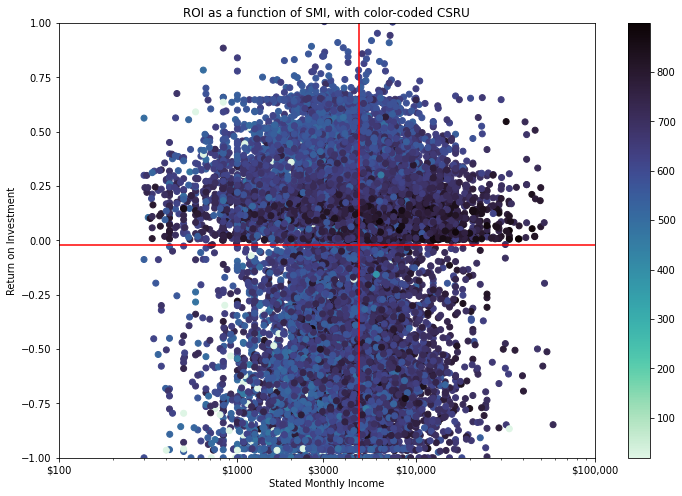

In [165]:
base_color = sb.color_palette()[0]
plt.figure(figsize = [12, 8])
plt.scatter(data = typical_incomes, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU')
plt.axvline(x=avg_smi, color='r')
plt.axhline(y=avg_roi, color='r')
plt.xlim(100, 100000)
plt.ylim(-1,1);

In [ ]:
typ_succ = typical_incomes[typical_incomes['NewLoanStatus']=='Successful'].copy()

typ_unsucc = typical_incomes[typical_incomes['NewLoanStatus']=='Unsuccessful'].copy()

In [ ]:
avg_smi_succ = typ_succ.StatedMonthlyIncome.mean()
avg_smi_succ

In [ ]:
avg_roi_succ = typ_succ.ROI.mean()
avg_roi_succ

In [ ]:
avg_smi_unsu = typ_unsucc.StatedMonthlyIncome.mean()
avg_roi_unsu = typ_unsucc.ROI.mean()

In [ ]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [20, 10])
base_color = sb.color_palette()[0]

# LEFT plot: SMI/CSRU/ROI - Successful loans
plt.subplot(1, 2, 1)
plt.scatter(data = typ_succ, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU')
plt.axvline(x=avg_smi_succ)
plt.axhline(y=avg_roi_succ)
plt.xlim(100, 100000)
plt.ylim(-1,1);
# RIGHT plot: box plot
plt.subplot(1, 2, 2)
plt.scatter(data = typ_unsucc, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title('ROI as a function of SMI, with color-coded CSRU - Uncompleted Loans')
plt.axvline(x=avg_smi_unsu)
plt.axhline(y=avg_roi_unsu)
plt.xlim(100, 100000)
plt.ylim(-1,1)
plt.show();


The blue lines are the means within typical income ranges. 

If the top left and bottom right quadrants have the most observations, there is a negative linear trend. That's what seems to be happening in the Successful graph. 

If the bottom left and top right quadrants have the most observations, there is a positive linear trend.

You can skip past the below calculations to a chart with the results of the various correlation tests.

In [ ]:
# run tests on typical_incomes without breaking it into successful and unsuccesful
typ_inc_roi_smi = typical_incomes[['ROI', 'StatedMonthlyIncome']].copy()

typ_inc_roi_smi.corr()

In [ ]:
typ_inc_roi_smi.corr(method='spearman')

In [ ]:
typ_inc_roi_csru = typical_incomes[['ROI', 'CreditScoreRangeUpper']].copy()

typ_inc_roi_csru.corr()

In [ ]:
typ_inc_roi_csru.corr(method='spearman')

In [ ]:
typ_inc_smi_csru = typical_incomes[['StatedMonthlyIncome', 'CreditScoreRangeUpper']].copy()

typ_inc_smi_csru.corr()

In [ ]:
typ_inc_smi_csru.corr(method='spearman')

In [ ]:
# run tests on typical_incomes, Successful Loans subset
ts_roi_smi = typ_succ[['ROI', 'StatedMonthlyIncome']].copy()

ts_roi_smi.corr()

In [ ]:
ts_roi_smi.corr(method='spearman')

In [ ]:
ts_smi_csru = typ_succ[['StatedMonthlyIncome', 'CreditScoreRangeUpper']].copy()

ts_smi_csru.corr()

In [ ]:
ts_smi_csru.corr(method='spearman')

In [ ]:
ts_roi_csru = typ_succ[['ROI', 'CreditScoreRangeUpper']].copy()

ts_roi_csru.corr()

In [ ]:
ts_roi_csru = typ_succ[['ROI', 'CreditScoreRangeUpper']].copy()

ts_roi_csru.corr(method='spearman')

In [ ]:
# run tests on typical_incomes, Unsuccessful Loans subset
ts_roi_smi_u = typ_unsucc[['ROI', 'StatedMonthlyIncome']].copy()

ts_roi_smi_u.corr(method='spearman')

In [ ]:
ts_roi_smi_u.corr()

In [ ]:
ts_roi_csru_u = typ_unsucc[['ROI', 'CreditScoreRangeUpper']].copy()

ts_roi_csru_u.corr()

In [ ]:
ts_roi_csru_u.corr(method='spearman')

In [ ]:
ts_smi_csru_u = typ_unsucc[['StatedMonthlyIncome', 'CreditScoreRangeUpper']].copy()

ts_smi_csru_u.corr()

In [ ]:
ts_smi_csru_u.corr(method='spearman')

#### Pearson and Spearman Results

First a review of the results from the full data set:

| Variables | Pearson | Spearman |
| --- | --- | --- |
| ROI / Credit Grade | NA | .138815 |
| ROI / Credit Score Range | .121623 | -.043215 |
| NLS / Credit Grade | NA | .201647 |
| NLS / Credit Score Range | NA | 265645 |
| NLS / Amount Delinquent | NA | -.150028 |
| ROI / NLS | NA | .722029 |
| Stated Monthly Income / Credit Score Range | .198644 | .240603 |
| Credit Grade / Credit Score Range | NA | .98771 |

In [ ]:
#### Results of correlation tests on typical_incomes dataframe

In [ ]:
# create an table to display the results of the Pearson and Spearman tests for monthly incomes between $300 and $30K
pear_spear = pd.DataFrame() 
 
# append columns to an empty DataFrame 
pear_spear['Variables'] = ['ROI/SMI', 'ROI/CSRU', 'SMI/CSRU'] 
pear_spear['Pearson'] = [.021068, .13776, .255158] 
pear_spear['Spearman'] = [-.004938, -.043328, .271839] 
pear_spear['Pear - Succ'] = [-.14123, -.562447, .252842] 
pear_spear['Spear - Succ'] = [-.124804, -.570404, .25707]
pear_spear['Pear - Unsu'] = [.026719, .068193, .252145]
pear_spear['Spear - Unsu'] = [.074707, .101959, .34411]

pear_spear.head(9)

When I removed all Stated Monthly Incomes under \\$300 or over \\$30K for the Successful Loans and Unsuccessful Loans subsets, the correlation scores got a little better than in the initial full data set. 

The pared-down data set (called "typical_incomes", even though \\$30K/month isn't very typical) also got larger correlation scores when broken into Successful and Unsuccessful loans than those subsets had received with the full data set (the full data set I studied here: loans originating from 2005 through 2008). 

The Successful Loan subset of the "typical_incomes" portion of the loans_to_2008 dataset appears to be the best correlations I can get with these investigations. At least of the manipulations that I have been able to think of. 

The biggenst news with the pared-down data set broken into Successful and Unsuccessful subsets, is that we finally got a ROI/SMI that was not considerably below |.1|: 

Succesful subset -.14123 pearson and -.124804 spearman (Unsuccessful subset still quite a bit below .1). 

The Successful ROI/CSRU was quite significant: -.562447 pearson and -.570404 spearman. 

And the SMI/CSRU score was signficant for both the Succesful (.252842 pearson and .25707 spearman) and Unsuccessful (.252145 pearson and .34411 spearman) subsets.

With the largest outliers removed, and the data broken into Successful Loans and Unsuccessful Loans subsets, Stated Monthly Income appears to be a fair predictor of ROI (Return on Investment) for the Successful loans, with a pearson score of -.14 and a spearman of -.12. Within that same Successful subset, CSRU appears to be a very good predictor of ROI (pearson -.562447 and spearman -.570404). Why the negative correlation? Why should ROI decrase when either SMI or CSRU increase? Remember that we are within the Successful subset, so almost all these loans have positive ROIs. Peopls with lower incomes tend to have lower credit ratings, so they are charged a higher rate; therefore, if they pay off their debt, the loan company makes more money than if someone with a higher credit rating pays off their debt. 

The moderate correlation between Stated Monthly Income and Credit Score Range Upper (about .26 for both pearsons and the Succseful Loans subset's spearman; and .34 spearman in the Unsuccessful Loans subset) helps to explain how it is possible for CSRU to track so much better to ROI than SMI.

Why did all tests of the Successful Loans subset yield scores well over |.1|, but only three of the Unsuccessful Loans subset's did: ROI/CSRU spearman (.1), and SMI / CSRU pearson (.25) and spearman (.34)? Is this related to the fact that the Successful Loans subset's ROI values are almost all between 0 and .75, but the Unsuccessful Loan subset's ROI values range from -1 through to .75? What is going on there?



#### Pearsons and Spearmans Tests on the typical_incomes dataframe: 

Below I ran Pearsons and Spearmans Correlation tests on the typical_incomes dataframe, and then on the Successful and Unsuccessful subsets of the typical_incomes dataframe. 

I don't know why the correspondence coefficients were a little different from the table above. The below tests rounded to only three digits (instead of the six digits above), but the difference seems a little bigger than that (when I round the six digit numbers up to three digit numbers, I don't get the exact numbers as the below results).

In any case, every p-value came up 0, except for ROI/SMI spearman (coefficient was -.003; p-value was .584).

What does a zero p-value mean in this case? that it is statistically impossible for these points to appear in this order without some underlying mathematical relationship existing between them? IE: It is impossible that these two variables could relate to each other in this way without there being a mathematical correspondence between them? Really? How now? I thought anything was possible. But maybe a vanishingly small p-value gets rounded up to zero, and that's the story here.

#### Correspondence tests on full dataframe

In [ ]:
from scipy.stats import spearmanr
from numpy.random import seed



def spear_score(var1, var2):
# seed random number generator
    seed(1)
# prepare data
    corr_data=typical_incomes.dropna(subset=[var1,var2]).copy()
    data1 = corr_data[var1]
    data2 = corr_data[var2]
# calculate spearman's correlation
    coef, p = spearmanr(data1, data2)
    print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
spear_score('ROI', 'StatedMonthlyIncome')

In [ ]:
spear_score('ROI', 'CreditScoreRangeUpper')

In [ ]:
spear_score('StatedMonthlyIncome', 'CreditScoreRangeUpper')

In [ ]:
spear_score('DebtToIncomeRatio','ROI')

In [ ]:
spear_score('AmountDelinquent','ROI')

In [ ]:
spear_score('ROI', 'NewLoanStatus')

In [ ]:
spear_score('StatedMonthlyIncome', 'NewLoanStatus')

In [ ]:
spear_score('CreditScoreRangeUpper', 'NewLoanStatus')

In [ ]:
# spear_score('ROI', 'NLSNumeric')

In [ ]:
from scipy.stats import pearsonr
from numpy.random import seed



def pears_score(var1, var2):
# seed random number generator
    seed(1)
# prepare data
    corr_data=typical_incomes.dropna(subset=[var1,var2]).copy()
    data1 = corr_data[var1]
    data2 = corr_data[var2]
# calculate spearman's correlation
    coef, p = pearsonr(data1, data2)
    print('Pearsons correlation coefficient: %.3f' % coef)
# interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
pears_score('ROI', 'StatedMonthlyIncome')

In [ ]:
pears_score('ROI', 'CreditScoreRangeUpper')

In [ ]:
pears_score('StatedMonthlyIncome', 'CreditScoreRangeUpper')

In [ ]:
pears_score('ROI', 'DebtToIncomeRatio')

In [ ]:
pears_score('ROI', 'AmountDelinquent')

In [ ]:
# pears_score('ROI', 'NewLoanStatus')

#### Correspondence Tests on Successful Loans subset

In [ ]:
def spear_score_succ(var1, var2):
# seed random number generator
    seed(1)
# prepare data
    corr_data=typ_succ.dropna(subset=[var1,var2]).copy()
    data1 = corr_data[var1]
    data2 = corr_data[var2]
# calculate spearman's correlation
    coef, p = spearmanr(data1, data2)
    print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
spear_score_succ('ROI', 'StatedMonthlyIncome')

In [ ]:
spear_score_succ('ROI', 'CreditScoreRangeUpper')

In [ ]:
spear_score_succ('StatedMonthlyIncome', 'CreditScoreRangeUpper')

In [ ]:
spear_score_succ('ROI', 'DebtToIncomeRatio')

In [ ]:
spear_score_succ('ROI', 'AmountDelinquent')

In [ ]:
spear_score_succ('ROI', 'NewLoanStatus')

In [ ]:
def pears_score_succ(var1, var2):
# seed random number generator
    seed(1)
# prepare data
    corr_data=typ_succ.dropna(subset=[var1,var2]).copy()
    data1 = corr_data[var1]
    data2 = corr_data[var2]
# calculate spearman's correlation
    coef, p = pearsonr(data1, data2)
    print('Pearsons correlation coefficient: %.3f' % coef)
# interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
pears_score_succ('ROI', 'StatedMonthlyIncome')

In [ ]:
pears_score_succ('ROI', 'CreditScoreRangeUpper')

In [ ]:
pears_score_succ('StatedMonthlyIncome', 'CreditScoreRangeUpper')

In [ ]:
pears_score_succ('ROI', 'AmountDelinquent')

In [ ]:
pears_score_succ('ROI', 'DebtToIncomeRatio')

#### Correspondence Tests on Unsuccessful Loans subset

In [ ]:
def spear_unsucc(var1, var2):
# seed random number generator
    seed(1)
# prepare data
    corr_data=typ_unsucc.dropna(subset=[var1,var2]).copy()
    data1 = corr_data[var1]
    data2 = corr_data[var2]
# calculate spearman's correlation
    coef, p = spearmanr(data1, data2)
    print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
spear_unsucc('ROI', 'StatedMonthlyIncome')

In [ ]:
spear_unsucc('ROI', 'CreditScoreRangeUpper')

In [ ]:
spear_unsucc('StatedMonthlyIncome', 'CreditScoreRangeUpper')

In [ ]:
spear_unsucc('ROI', 'AmountDelinquent')

In [ ]:
spear_unsucc('ROI', 'DebtToIncomeRatio')

In [ ]:
def pears_unsucc(var1, var2):
# seed random number generator
    seed(1)
# prepare data
    corr_data=typ_unsucc.dropna(subset=[var1,var2]).copy()
    data1 = corr_data[var1]
    data2 = corr_data[var2]
# calculate spearman's correlation
    coef, p = pearsonr(data1, data2)
    print('Pearsons correlation coefficient: %.3f' % coef)
# interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
pears_unsucc('ROI', 'StatedMonthlyIncome')

In [ ]:
pears_unsucc('ROI', 'CreditScoreRangeUpper')

In [ ]:
pears_unsucc('StatedMonthlyIncome', 'CreditScoreRangeUpper')

In [ ]:
pears_unsucc('ROI', 'DebtToIncomeRatio')

In [ ]:
pears_unsucc('ROI', 'AmountDelinquent')

| Variables | Pearson | Spearman |
| -- | Monthly Incomes between 300 and 30K | -- |
| ROI / SMI | .021068 | -.004938 |
| ROI / CSRU | .13776 | -.043328 |
| SMI / CSRU | .255158 | .274839 |
| :- | Successful Loans | :-: |
| ROI / SMI | -.14123 | -.124804 |
| ROI / CSRU | -.562447 | -.570404 |
| SMI / CSRU | .252842 | .25707 |
| :- | Unsuccessful Loans | :-: |
| ROI / SMI | .026719 | .074707 |
| ROI / CSRU |.068193 | .101959 |
| SMI / CSRU | .252145 | .34411 |

| Variables | Result | Pearson | Spearman |
| --- | --- | --- |
| ROI / Credit Grade | NA | .138815 |
| ROI / Credit Score Range | .121623 | -.043215 |
| NLS / Credit Grade | NA | .201647 |
| NLS / Credit Score Range | NA | 265645 |
| NLS / Amount Delinquent | NA | -.150028 |
| ROI / NLS | NA | .722029 |
| Stated Monthly Income / Credit Score Range | .198644 | .240603 |
| Credit Grade / Credit Score Range | NA | .98771 |

revised my comments on the multivariables plots for clarity
I am facing a couple statistical questions that I would like help with:
(1) why do the medians in the ROI versus CreditRange box plots increase slightly as we go from AA through D?
(2) why do the medians in the ROI versus Incomerange box plots hold pretty steady across all income ranges/
(3) I broke the data into graphs of ROI vs SMI into Successful and Unsuccessful loans
The Successful subset's ROI plot looked like the top of a mushroom floating in space.
All the ROIs were positive, and they gradually increased with SMI until incomes of about $6K, and then gradually decreasing.
The Unsuccessful subset's ROI looked like the end of a spike.
It's values started at negative one, but reached the same peak ROI as the Successful subset at the same income ($6K).
Furthermore, while the ascent and descent were much steeper, the Unsuccessful subset's ROI also sloped uniformly up and down from the peak, just as the Successful subset had.
When I ran pearsons on the ROI/SMI plot within the Successful subset, the Unsuccessful subset, and the complete data, my findings are as follows:
about -.1; about .03, about .02
I can maybe understand the small negative correlation: at first as monthly income increases, ROIs increase; but as monthly incomes really take off, ROIs start to go down. Maybe, because the SMI is growing exponentially, the negative correlation on the downward slope more than counteracts the initial positive correlation.
But why should the Unsuccessful subset's and the aggregate data's ROI/SMI be insignificant?
And then I isolated just those incomes, within the Successful subset, that correlated with increasing ROIs.
I got a pearson of -.06
That is incoherent. A clearly visible positive correlation (as SMI increases, so does ROI in this subset over this interval). And a very small NEGATIVE pearson's score? This makes no sense.

And two non-statistics question:
(1) Why does
typical_incomes.groupby('StatedMonthlyIncome').describe()
keep crashing my jupyter notebook?
(2) in Credit Grade, what does HR stand for?